In [1]:
from params import *
from Dataset import get_dataloader
from Model import SKModel

import numpy as np
import pandas as pd

import IPython
import matplotlib.pyplot as plt
import matplotlib.backend_bases as mpl
%matplotlib widget
import seaborn as sns

import os
import shutil
import glob
import time
import sys

import re
import pretty_midi
import librosa

from sklearn.linear_model import SGDRegressor, Perceptron, LogisticRegression
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import LearningCurveDisplay, train_test_split
from sklearn.metrics import classification_report, accuracy_score

import torch
import torchaudio

from mido import MidiFile


%load_ext autoreload
%autoreload 2


# Looking at our data

### Metadata

In [2]:
mid = pretty_midi.PrettyMIDI('data/musicnet_midis/Schubert/1727_schubert_op114_2.mid')
mid.instruments

[Instrument(program=40, is_drum=False, name="Violin"),
 Instrument(program=41, is_drum=False, name="Viola"),
 Instrument(program=42, is_drum=False, name="Cello"),
 Instrument(program=43, is_drum=False, name="Contrabass"),
 Instrument(program=0, is_drum=False, name="Pianoforte")]

In [3]:
meta = pd.read_csv(r"data\musicnet_metadata.csv")
meta.head(3)

id  composer               composition                   movement  \
0  1727  Schubert  Piano Quintet in A major                 2. Andante   
1  1728  Schubert  Piano Quintet in A major         3. Scherzo: Presto   
2  1729  Schubert  Piano Quintet in A major  4. Andantino - Allegretto   

        ensemble            source                      transcriber  \
0  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
1  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
2  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   

  catalog_name  seconds  
0        OP114      447  
1        OP114      251  
2        OP114      444

In [4]:
meta = meta.drop(columns=["composition","movement", "ensemble", "source", "transcriber", "catalog_name"])
meta.head(5)

id  composer  seconds
0  1727  Schubert      447
1  1728  Schubert      251
2  1729  Schubert      444
3  1730  Schubert      368
4  1733  Schubert      546

In [5]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        330 non-null    int64 
 1   composer  330 non-null    object
 2   seconds   330 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ KB


### Sound files

AudioMetaData(sample_rate=44100, num_frames=19715328, num_channels=1, bits_per_sample=32, encoding=PCM_F)
number of features: 19715328


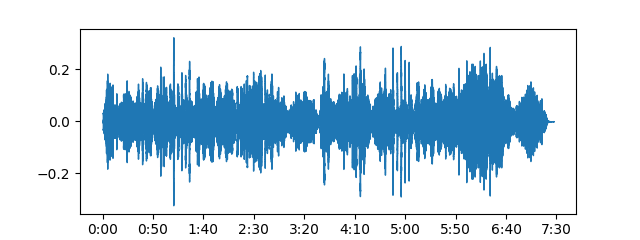

In [6]:
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH)

print(torchaudio.info(AUDIO_EXAMPLE_PATH))
print("number of features: {}".format(len(samples1[0])))

fig, ax1 = plt.subplots(1,figsize=(6.4,2.4))
librosa.display.waveshow(y=samples1.numpy(),sr=sr1,ax=ax1)
plt.show()


We take only a sample of the initial audio file and reduce the sampling rate to get a dramatic decrease in number of features

number of features 1: 220500, number of features 2: 40000


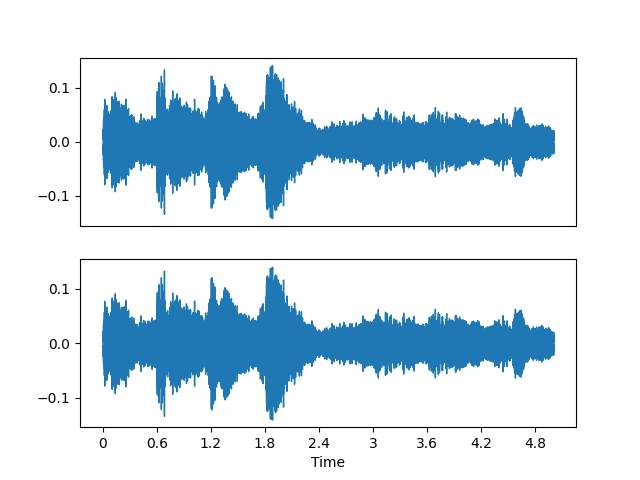

In [7]:
#Sample from second 8
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=AUDIO_EXAMPLE_OFFSET_SEC*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples2 = torchaudio.functional.resample(samples1,sr1,SAMPLING_RATE)

print("number of features 1: {}, number of features 2: {}".format(len(samples1[0]),len(samples2[0])))

fig, (ax1,ax2) = plt.subplots(2,1)
librosa.display.waveshow(y=samples1.numpy(),sr=sr1,ax=ax1,axis=None)
librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=ax2)
plt.show()

In [8]:
IPython.display.display(IPython.display.Audio(samples1,rate=sr1))
IPython.display.display(IPython.display.Audio(samples2,rate=SAMPLING_RATE))


We lose some audio quality but really not that much!

# Creating our dataset

run this cell once

In [9]:
#Move the files to the desired directory
def create_dataset(df:pd.DataFrame):
    samples = {sample[:-4]:"train" for sample in  os.listdir('data/musicnet/train_data')}
    samples.update({sample[:-4]:"test" for sample in  os.listdir('data/musicnet/test_data')})
    
    instrument_data = []
    
    for path in glob.glob('data/musicnet_midis/*/*.mid'):
        id = re.sub("_.*","",os.path.basename(path))
        if id in samples:
            #keep only samples where we can access the midi file
            try: 
                mid = pretty_midi.PrettyMIDI(path)

                #load and save wav files as tensors
                sample_data,sr = torchaudio.load(f"data/musicnet/{samples[id]}_data/{id}.wav")
                sample_data = torchaudio.functional.resample(sample_data,sr,SAMPLING_RATE)
                torch.save(sample_data,f'data\{samples[id]}\{id}.pt')


                #Create instrument labels
                label = {"id":int(id), "path":f'data\{samples[id]}\{id}.pt', "train":samples[id]=="train"}
                label.update({instrument.program:1 for instrument in  mid.instruments})
                instrument_data.append(label)

            #remove "bad" samples
            except:
                print(f"could not load file: {path}")
                shutil.move(f"data/musicnet/{samples[id]}_data/{id}.wav",f"data/bad_data/{samples[id]}_data/{id}.wav")

    instrument_df = pd.DataFrame.from_records(instrument_data)
    return df.merge(instrument_df, on="id",how="right")

#Create the new metadata only if it doesnt exists
if os.path.exists(RAW_LABELS_CSV_DIR) == False:
    df = create_dataset(meta)
    df.to_csv(RAW_LABELS_CSV_DIR,index=False)

df = pd.read_csv(RAW_LABELS_CSV_DIR)

## Data labeling

In [10]:
df = df[df["train"]]
df = df.drop(columns="train").reset_index(drop=True)
df.head(5)

id composer  seconds                path   40   41    0  73  42   6  45  \
0  2186     Bach      214  data\train\2186.pt  1.0  1.0  NaN NaN NaN NaN NaN   
1  2195     Bach      155  data\train\2195.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
2  2196     Bach       75  data\train\2196.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
3  2198     Bach      197  data\train\2198.pt  NaN  NaN  1.0 NaN NaN NaN NaN   
4  2200     Bach      113  data\train\2200.pt  NaN  NaN  1.0 NaN NaN NaN NaN   

   71  70  60  68  43  
0 NaN NaN NaN NaN NaN  
1 NaN NaN NaN NaN NaN  
2 NaN NaN NaN NaN NaN  
3 NaN NaN NaN NaN NaN  
4 NaN NaN NaN NaN NaN

setting NaN values to 0

In [11]:
FIRST_COLS = ["id", "composer", "seconds", "path"]
def populate_dataset(df:pd.DataFrame):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    df = df.fillna(0)
    df = df.loc[:,  FIRST_COLS + numerical_cols]
    df = df.set_index("id")
    
    return df 

df = populate_dataset(df)
df.head(5)

composer  seconds                path    0   40   41   42   43   45    6  \
id                                                                              
2186     Bach      214  data\train\2186.pt  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2195     Bach      155  data\train\2195.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2196     Bach       75  data\train\2196.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2198     Bach      197  data\train\2198.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2200     Bach      113  data\train\2200.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

       60   68   70   71   73  
id                             
2186  0.0  0.0  0.0  0.0  0.0  
2195  0.0  0.0  0.0  0.0  0.0  
2196  0.0  0.0  0.0  0.0  0.0  
2198  0.0  0.0  0.0  0.0  0.0  
2200  0.0  0.0  0.0  0.0  0.0

In [12]:
def plot_data_dis(df,fig,ax1,ax2):
    def onPick(event:mpl.PickEvent):
        numerical_cols = list(df.columns.difference(FIRST_COLS))
        
        if event.mouseevent.button != 1:
            return
       
        patches = ax1.get_children()
        for p in patches:
            if p.properties()["picker"] == 5:
                p.remove()
                
        patches = ax2.get_children()
        for p in patches:
            if p.properties()["picker"] == 5:
                p.remove()
                
        
        
        num = int(np.rint(event.mouseevent.xdata))
        if event.mouseevent.inaxes.get_title() == "Composer distribution":
            if num in range(len(ax2_x)):
                y = df[df['composer']==ax2_x.index[num]][numerical_cols].sum()
                y = y[y>0]
                info = ["{}\n{:.2%}".format(v,v/ax1_y[k]) for k,v in y.items() ]
                p = ax1.bar(y.index,y,label=ax2_x.index[num],picker=5)
                ax1.bar_label(p,label_type='center',labels=info,picker=5)

                
                p = ax2.bar(ax2_x.index[num],ax2_y[ax2_x.index[num]],label=ax2_x.index[num],picker=5)
                
                


        else:
            if num in range(len(numerical_cols)):
                
                
                y = df[numerical_cols][df[numerical_cols[num]] == 1].sum()
                y = y[y>0]
                info = ["{}\n{:.2%}".format(v,v/ax1_y[k]) for k,v in y.items() ]
                p = ax1.bar(y.index,y,label=numerical_cols[num],picker=5)
                ax1.bar_label(p,label_type='center',labels=info,picker=5)

                y = df[df[numerical_cols[num]] == 1]['composer'].value_counts().astype(int)
                info = ["{}\n{:.2%}".format(v,v/ax2_y[k]) for k,v in y.items() ]
                p = ax2.bar(y.index,y,label=numerical_cols[num],picker=5)
                ax2.bar_label(p,label_type='center',labels=info,picker=5)
            
            
            

            

    
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    ax1_x = (df[numerical_cols].sum()*0+1).cumsum()-1
    ax1_y = df[numerical_cols].sum()
    p = ax1.bar(ax1_x.index, ax1_y,picker=True)
    ax1.bar_label(p,fmt=lambda h: "{}\n{:.2%}".format(int(h),h/len(df)))

    ax1.set_xticks(ax1_x)
    ax1.set_xticklabels(ax1_x.index)
    ax1.set_title("Instrument occurrences")
    ax1.set_ylabel("# Samples")
    ax1.set_xlabel("Instrument number")


    
    
    ax2_x = (df.composer.value_counts()*0 + 1).cumsum()-1
    ax2_y = df.composer.value_counts()
    ax2.bar(ax2_x.index, ax2_y,picker=True)
    for i, h in enumerate(ax2_y):
        ax2.text(i,h,h, horizontalalignment='center',va='bottom')
    x_labels = ax2_x.index
    
    ax2.set_xticks(ax2_x)
    ax2.set_xticklabels(x_labels)
    ax2.set_ylabel("# Samples")
    ax2.set_xlabel("Composer")
    ax2.set_title("Composer distribution")
    
    fig.canvas.mpl_connect('pick_event',onPick)
    return ax1,ax2



Try clicking on instruments

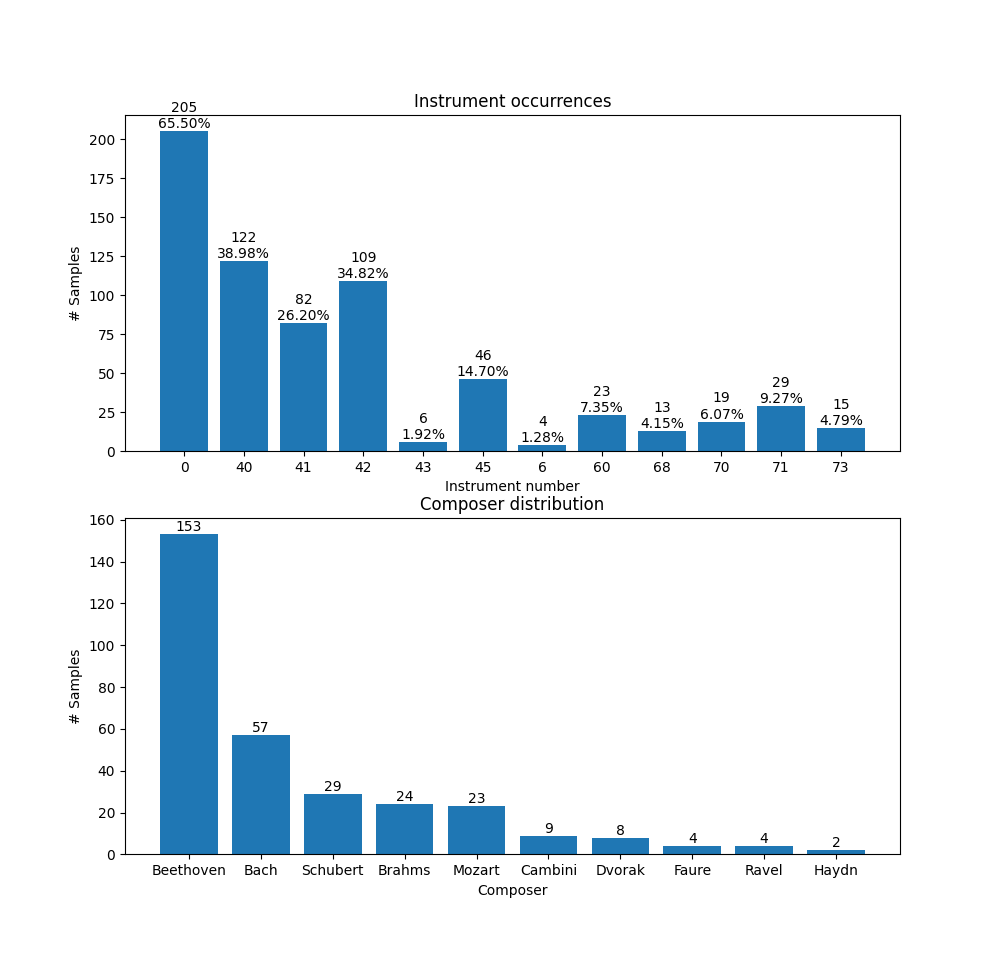

In [13]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,9.6))
ax1, ax2 = plot_data_dis(df,fig,ax1,ax2)

### Cleaning Data

Removing labels that have a low amount of samples

In [14]:
def remove_outliers(df,min_instrument=10, min_composer=5, iters=5):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    drop_composers = []
    for _ in range(iters):
        mask = (df[numerical_cols].sum() < min_instrument) &  (df[numerical_cols].sum() != 0)
        drop1 = mask[mask==True].index
        for i in drop1:
            df = df[df[i]!=1]

        mask = (df.composer.value_counts()<min_composer)
        drop2 = mask[mask==True].index
        
        if len(drop1)==0 and len(drop2)==0: 
            break

        for i in drop2:
            df = df[df["composer"] != i]
            drop_composers.append(i)

    
    mask = (df[numerical_cols].sum() == 0) 
    drop_instruments = mask[mask==True].index
    df = df.drop(columns=drop_instruments)
    return df, drop_instruments, drop_composers

Setting a hard limit on the number of samples in the dataset

Note: during training and testing each one label may correspond to multiple samples from the same audio file

In [15]:
def drop_excess_samples(df):
    while df['composer'].value_counts().max()-MAX_COMPOSER_SAMPLES > 0:
        composer_samples = df[df['composer']==df['composer'].value_counts().idxmax()]
        n = df['composer'].value_counts().max()-MAX_COMPOSER_SAMPLES
        df = df.drop(index=composer_samples.sample(n).index)
    return df

Ensure we have the same number of composers for a more accurate evaluation

In [16]:
def balance_composers(df):
    max_samples = MAX_COMPOSER_SAMPLES
    temp = df['composer'].value_counts() < max_samples
    for comp in temp.index:
        n = max_samples-df['composer'].value_counts()[comp]
        if n > 0:
            composer_samples = df[df['composer']==comp]
            df = pd.concat([df, composer_samples.sample(n,replace=True)])
    return df

In [17]:
df, drop_instruments, drop_composers = remove_outliers(df)
df = drop_excess_samples(df)
df = balance_composers(df)
df

composer  seconds                path    0   40   41   42   45   60   68  \
id                                                                              
2186     Bach      214  data\train\2186.pt  0.0  1.0  1.0  0.0  0.0  0.0  0.0   
2195     Bach      155  data\train\2195.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2196     Bach       75  data\train\2196.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2198     Bach      197  data\train\2198.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
2200     Bach      113  data\train\2200.pt  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
...       ...      ...                 ...  ...  ...  ...  ...  ...  ...  ...   
1918   Dvorak      367  data\train\1918.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
1932   Dvorak      250  data\train\1932.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
1916   Dvorak      675  data\train\1916.pt  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1923   Dvorak      393  data\train\1923.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
1923   Dvorak      393  data\train\1923.pt  0.0  1.0  1.0  1.0  1.0  0.0  0.0   

       70   71   73  
id                   
2186  0.0  0.0  0.0  
2195  0.0  0.0  0.0  
2196  0.0  0.0  0.0  
2198  0.0  0.0  0.0  
2200  0.0  0.0  0.0  
...   ...  ...  ...  
1918  0.0  0.0  0.0  
1932  0.0  0.0  0.0  
1916  0.0  0.0  0.0  
1923  0.0  0.0  0.0  
1923  0.0  0.0  0.0  

[1050 rows x 13 columns]

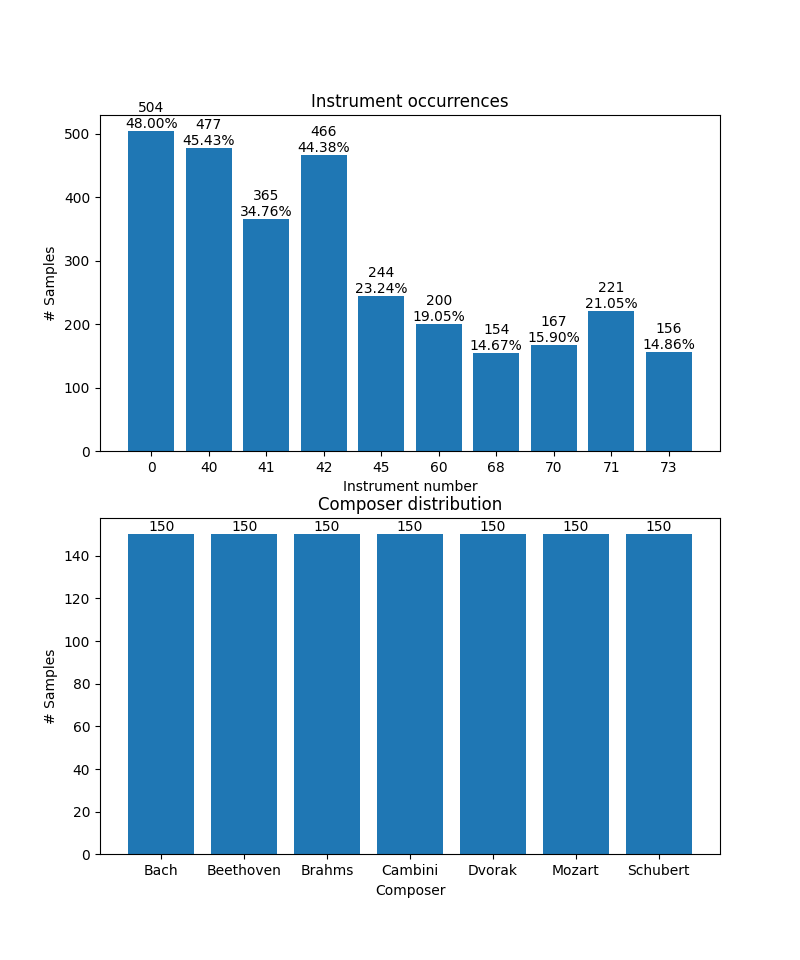

In [18]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,9.6))
ax1, ax2 = plot_data_dis(df,fig,ax1,ax2)
plt.show()

In [19]:
df.nunique()

composer      7
seconds     237
path        290
0             2
40            2
41            2
42            2
45            2
60            2
68            2
70            2
71            2
73            2
dtype: int64

## Test set

Since the test set from kaggle is small we will ensure the testing set has at least one sample from each class

In [20]:
def modify_test(test_df:pd.DataFrame,train_df:pd.DataFrame,drop_composers,drop_instruments,sample_train=1):
    
    for comp in drop_composers:
        test_df = test_df[test_df["composer"] != comp]
    for inst in drop_instruments:
        test_df = test_df[test_df[inst] != 1]
    test_df = test_df.drop(columns=drop_instruments)


    #Test is quite small so we artificially create more samples by taking away from train
    numerical_cols = np.sort(train_df.columns.difference(FIRST_COLS)).tolist()
    #ensure at least 1 sample from each class
    a = train_df.groupby(numerical_cols,group_keys=False)[train_df.columns].apply(lambda df: df.sample(sample_train),include_groups=True)
    b = train_df.groupby('composer',group_keys=False)[train_df.columns].apply(lambda df: df.sample(sample_train),include_groups=True)
    test_df = pd.concat([test_df,a,b]).drop_duplicates()
    train_df = train_df.drop(pd.concat([a,b]).index)
    return test_df,train_df
    

In [21]:
def load_data():
    
    if os.path.exists(RAW_LABELS_CSV_DIR) == False:
        df = create_dataset(meta)
        df.to_csv(RAW_LABELS_CSV_DIR)
    df = pd.read_csv(RAW_LABELS_CSV_DIR)
    train_df = df[df["train"]==True].drop(columns="train").reset_index(drop=True)
    test_df =  df[df["train"]==False].drop(columns="train").reset_index(drop=True)
    
    train_df = populate_dataset(train_df)
    test_df = populate_dataset(test_df)

    train_df,drop_instruments,drop_composers = remove_outliers(train_df)
    test_df,train_df = modify_test(test_df,train_df,drop_composers,drop_instruments)
    print("Test size:",len(test_df))
    
    
    train_df = drop_excess_samples(train_df)
    print('"Unique" train samples:',len(train_df))
    train_df = balance_composers(train_df)
    print("Total train size:",len(train_df))
    

    le = LabelEncoder()
    train_df["composer"] = le.fit_transform(train_df["composer"])
    test_df["composer"] = le.transform(test_df["composer"])
    return train_df, test_df

train_df,test_df =  load_data()

Test size: 37
"Unique" train samples: 265
Total train size: 1050


In [22]:
def getClasses(df):
    numerical_cols = np.sort(df.columns.difference(FIRST_COLS)).tolist()
    return [[0,1] for i in range(len(numerical_cols)) ], df.composer.unique()

INSTRUMENT_CLASSES, COMPOSER_CLASSES = getClasses(train_df)

# Data loading
### Train - Val split

In [23]:
X = train_df.path.to_numpy()
Y = train_df
test_x = test_df.path.to_numpy()
test_y = test_df

train_x, val_x, train_y, val_y = train_test_split(X,Y,test_size=SPLIT_SIZE,random_state=42)

In [24]:
train_x.shape, val_x.shape, test_x.shape

((315,), (735,), (37,))

We will be using pytorch's dataloader to load batches of data, for more info go to dataset.py

## Benchmarking

In [25]:
# def sizeof_fmt(var,name="", suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     num = sys.getsizeof(var)
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             size = "%3.1f %s%s" % (num, unit, suffix)
#             print("{:>30} size: {:>8}".format(name, size))
#             return
#         num /= 1024.0
#     size = "%3.1f %s%s" % (num, unit, suffix)
#     print("{:>30} size: {:>8}".format(name, size))
#     return


    

# def mean_time(epoches,loader):
#     total_time = 0
#     total_samples = 0
#     total_batches = 0
#     for i in range(epoches):
#         num_samples = 0
#         num_batches = 0
#         total_epoch_time = 0
#         sample = torch.zeros(1)
#         start = time.time()
#         for s in loader:
#             sample_time = time.time() - start
            
#             sample = s[0]
#             total_epoch_time += sample_time
#             num_samples += len(s[0])
#             num_batches += 1
#             start = time.time()

#         total_batches += num_batches
#         total_samples += num_samples
#         total_time += total_epoch_time

#         avg_batch_time = total_epoch_time/num_batches
#         avg_sample_time = total_epoch_time/num_samples
#         print("Device: {}, Total run time for epoch {}: {:.4f}, Average batch load time: {:.5f}, Average sample load time: {:.6f}".format(sample.device,i,total_epoch_time,avg_batch_time,avg_sample_time))

#     avg_epoch_time = total_time/epoches
#     avg_sample_time = total_time/total_samples
#     avg_batch_time = total_time/total_batches
#     print("--------------------------------------------------------------------")
#     print("Total run time for {} epoches: {:.3f}, Average epoch time: {:.4f}, Average batch load time: {:.5f}, Average sample load time: {:.6f}".format(epoches,total_time,avg_epoch_time,avg_batch_time,avg_sample_time))


In [26]:
# train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0)
# mean_time(10,train_loader)
# sizeof_fmt(train_ds)
# del train_ds
# del train_loader

In [27]:
# train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,cache_size=400)
# mean_time(10,train_loader)
# sizeof_fmt(train_ds)
# del train_ds
# del train_loader

In [28]:
# train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,preload=True)
# mean_time(10,train_loader)
# sizeof_fmt(train_ds)
# del train_ds
# del train_loader

In [29]:
# train_ds,train_loader = get_dataloader(train_x,Y,64,mode=2,preload=True,device=DEVICE)
# mean_time(10,train_loader)
# sizeof_fmt(train_ds)
# del train_ds
# del train_loader

In [30]:
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=0,cache_size=400)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=0,cache_size=200)

In [31]:
a,l1 = train_ds[0]
b,l2 = train_ds[0]
#Each item in the dataloader samples a random section of the audio file. We may get many samples that all match the same label
(a-b).sum(), l1[0] == l2[0], all(l1[1]==l2[1])

(tensor(-0.6661), True, True)

Dataset generator for offline models

In [32]:
def generate_samples(loader,factor = 1):
    samples_x = []
    samples_y1 = []
    samples_y2 = []
    for i in range(factor):
        for x,y in loader:
            samples_x = samples_x + x.tolist()
            samples_y1 = samples_y1 + y[0].tolist()
            samples_y2 = samples_y2 + y[1].tolist()

    return np.array(samples_x), (np.array(samples_y1), np.array(samples_y2))


# Training

For now let's focus on composer only

In [33]:
#Not many samples at all!!
x,y = generate_samples(train_loader,1)
xVal,yVal = generate_samples(val_loader,1)
x.shape

(315, 40000)

## Offline models (attempt)

- SVC
- KNN
- Adaboost

In [34]:


common_params = {
    "X": x,
    "y": y[0],
    "train_sizes": np.linspace(0.2, 1.0, 5),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

# model_svc = SVC(random_state=42,verbose=True)
# LearningCurveDisplay.from_estimator(model_svc, **common_params)


Maybe a neighbors based model can perform better?

In [35]:


# knn_model = KNeighborsClassifier(3,n_jobs=-1)
# LearningCurveDisplay.from_estimator(knn_model, **common_params)


Let's try a much complex model

In [36]:


# weak_model = LogisticRegression(n_jobs = -1)
# model_adaboost = AdaBoostClassifier(weak_model,n_estimators=100)
# LearningCurveDisplay.from_estimator(model_adaboost, **common_params)
# model_adaboost.fit(x,y[0])

In [37]:
# pred = model_adaboost.predict(x)
# print(classification_report(y[0],pred))

In [38]:
# pred = model_adaboost.predict(xVal)
# print(classification_report(yVal[0],pred))

840 samples is clearly not enough...

Warning!! This might be a bad idea... 
```python
x,y = generate_samples(train_loader,100)
```

## Online learning

The actual number of samples in our dataset is massive, and each sample has a large number of features

Instead of loading all the data at once, we load the data in mini-batches

In [39]:
def printPerformance(acc1,acc2,acc3,acc4,acc5, level=0, name=""):
    model_acc2 = ["{:.2%}".format(acc) for acc in acc2]
    if level <= 0:
        print("{}: accuracy composer: {:.2%}    accuracy instrument: {:.2%} -> ".format(name,acc1,np.mean(acc2)),model_acc2)
        return
    print(f"{name}:")
    print("exact match: {:.2%}    accuracy composer: {:.2%}    exact accuracy instrument: {:.2%}".format(acc4,acc1,acc3))
    print("combined accuracy: {:.2%}    accuracy instrument: {:.2%} -> ".format(acc5,np.mean(acc2)),model_acc2)
    return



def evaluate_models(models:list[SKModel], loader, train=False, first=False):
    num_correct_1 = np.zeros(len(models))
    num_correct_2 = np.zeros((len(models),len(INSTRUMENT_CLASSES)))
    num_correct_3 = np.zeros(len(models))
    num_correct_4 = np.zeros(len(models))
    num_samples = 0
    for _, (x,y) in enumerate(loader):
        
        try:
            for i, model in enumerate(models):
                pred = model.predict(x)
                num_correct_1[i] += np.sum(pred[0]==y[0].numpy())
                num_correct_2[i] += np.sum((pred[1] == y[1].numpy()),axis=0)
                num_correct_3[i] += np.sum(np.prod((pred[1] == y[1].numpy()),axis=1))
                correct_1 = pred[0]==y[0].numpy()
                correct_2 = np.prod((pred[1] == y[1].numpy()),axis=1) == 1
                num_correct_4[i] += np.sum(correct_1 * correct_2)
            num_samples += len(x)
        except Exception:
            pass
            
        if train:
            for i, model in enumerate(models):
                model.partial_fit(x,y,classes=[COMPOSER_CLASSES,INSTRUMENT_CLASSES])
            
        

    comp_accuracy = num_correct_1/num_samples
    inst_accuracies = num_correct_2/num_samples
    inst_exact_accuracy = num_correct_3/num_samples
    exact_accuracy = num_correct_4/num_samples 
    overall_accuracy = (comp_accuracy + np.mean(inst_accuracies,axis=1))/2
        
    return  comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy

def train_loop(models:list[SKModel],train_loader,val_loader,epoches=EPOCHS,eval_every=EVAL_EVERY,verbose=4):
    
    hist_comp = [{"train_accuracy":{},"val_accuracy":{}} for i in range(len(models))]
    hist_inst = [{"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}} for i in range(len(models))]
    hist_model = [{"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}} for i in range(len(models))]
    
    
    
    for e in range(epoches):
        if verbose>0:
            print('EPOCH %d' % (e))
        start = time.time()
        acc1,acc2,acc3,acc4,acc5 = evaluate_models(models,loader=train_loader,train=True)
        if verbose>0:
            print("epoch time:",time.time()-start)

        if verbose > 0:
            for i in range(len(models)):
                if verbose > 2 or (verbose > 1 and (e%eval_every == 0 or e==epoches-1)):
                    printPerformance(acc1[i],acc2[i],acc3[i],acc4[i],acc5[i],name=f"train model {i}",level = verbose-3)
                hist_comp[i]["train_accuracy"][e]=acc1[i]
                hist_inst[i]["train_accuracy"][e]=acc2[i]
                hist_inst[i]["train_accuracy_exact"][e] = acc3[i]
                hist_model[i]["train_accuracy_exact"][e] = acc4[i]
                hist_model[i]["train_accuracy"][e] = acc5[i]
            if verbose > 2 or  (e%eval_every == 0 or e==epoches-1):
                print("")

        if verbose>0 and (e%eval_every == 0 or e==epoches-1):
            acc1,acc2,acc3,acc4,acc5 = evaluate_models(models,val_loader)
            for i in range(len(models)):
                if verbose > 1:
                    printPerformance(acc1[i],acc2[i],acc3[i],acc4[i],acc5[i],name=f"val model {i}",level = verbose-3)
                hist_comp[i]["val_accuracy"][e]=acc1[i]
                hist_inst[i]["val_accuracy"][e]=acc2[i]
                hist_inst[i]["val_accuracy_exact"][e] = acc3[i]
                hist_model[i]["val_accuracy_exact"][e] = acc4[i]
                hist_model[i]["val_accuracy"][e] = acc5[i]
            if verbose>1:
                print("----------------------------------------------")
                print("")
                print("")

    return models, hist_comp, hist_inst, hist_model

### Linear models

In [40]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.multioutput import MultiOutputClassifier

# composer = Perceptron()
# instrument = MultiOutputClassifier(Perceptron(), n_jobs=-1)
# model1 = SKModel(composer,instrument,withScalar=True)


# composer = SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001, n_jobs=-1)
# instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001, n_jobs=-1), n_jobs=-1)
# model2 = SKModel(composer,instrument,withScalar=True)


# composer = SGDClassifier(loss='modified_huber',alpha=0.00001,learning_rate='adaptive',eta0=0.0001, n_jobs=-1)
# instrument = MultiOutputClassifier(SGDClassifier(loss='modified_huber',alpha=0.00001,learning_rate='adaptive',eta0=0.0001, n_jobs=-1), n_jobs=-1)
# model3 = SKModel(composer,instrument,withScalar=True)


# composer = SGDClassifier(loss='hinge',alpha=0.00001,learning_rate='adaptive',eta0=0.0001, n_jobs=-1)
# instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=0.00001,learning_rate='adaptive',eta0=0.0001, n_jobs=-1), n_jobs=-1)
# model4 = SKModel(composer,instrument,withScalar=True)



composer = Perceptron(n_jobs=-1)
instrument = MultiOutputClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
model1 = SKModel(composer,instrument,withScalar=True)


composer = SGDClassifier(loss='log_loss',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=ALPHA,learning_rate='adaptive',eta0=0.0001,n_jobs=-1), n_jobs=-1)
model2 = SKModel(composer,instrument,withScalar=True)

composer = SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model3 = SKModel(composer,instrument,withScalar=True)


models1 = [model1,model2,model3]

10 epoches is like
```python
x,y = generate_samples(train_loader,10)
```

In [41]:
models1, hist_comp1, hist_inst1, hist_models1 = train_loop(models1,train_loader,val_loader,epoches=EPOCHS)

EPOCH 0
epoch time: 7.7215800285339355
train model 0:
exact match: 2.39%    accuracy composer: 19.92%    exact accuracy instrument: 5.58%
combined accuracy: 33.67%    accuracy instrument: 47.41% ->  ['56.97%', '56.18%', '49.80%', '46.22%', '43.82%', '42.23%', '39.04%', '43.03%', '55.38%', '41.43%']
train model 1:
exact match: 1.99%    accuracy composer: 17.53%    exact accuracy instrument: 3.59%
combined accuracy: 30.82%    accuracy instrument: 44.10% ->  ['57.77%', '54.58%', '43.43%', '52.59%', '37.85%', '41.43%', '35.06%', '37.45%', '49.00%', '31.87%']
train model 2:
exact match: 1.20%    accuracy composer: 21.12%    exact accuracy instrument: 1.20%
combined accuracy: 27.53%    accuracy instrument: 33.94% ->  ['56.57%', '51.79%', '43.82%', '51.00%', '32.27%', '19.52%', '18.73%', '22.71%', '25.90%', '17.13%']

val model 0:
exact match: 1.63%    accuracy composer: 19.18%    exact accuracy instrument: 4.08%
combined accuracy: 33.80%    accuracy instrument: 48.41% ->  ['50.48%', '52.52%'

Seems like the online models are getting more consistent results... but they are not great...

Maybe the issues are the features themselves?

# Data transformation

In [42]:
samples1,sr1 = torchaudio.load(AUDIO_EXAMPLE_PATH, frame_offset=AUDIO_EXAMPLE_OFFSET_SEC*sr1,num_frames=SAMPLE_LENGTH*sr1)
samples2 = torchaudio.functional.resample(samples1,sr1,SAMPLING_RATE)

## Fast Fourier Transform (FFT)

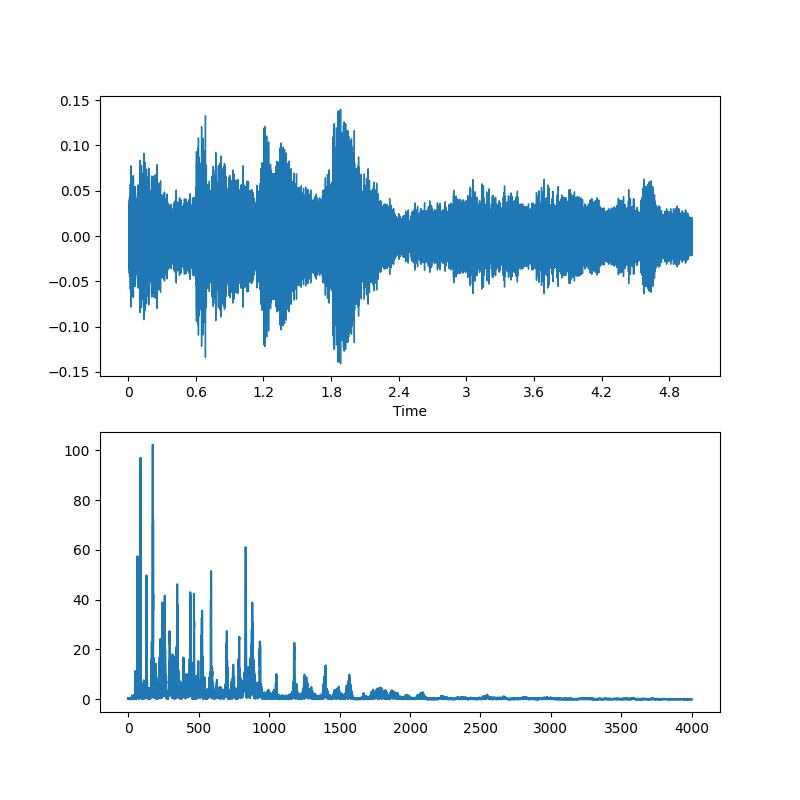

In [43]:
def plot_fft(sample, sr, ax:plt.Axes):
    y = 1/len(sample) * np.abs(np.fft.fft(sample))[:len(sample)//2]
    y = np.abs(np.fft.fft(sample))[:len(sample)//2]
    x = np.linspace(0.0,sr/2.0,len(sample)//2)
    ax.plot(x,y)

fig, axes = plt.subplots(2,1,figsize=(8,8))
librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=axes[0])
plot_fft(samples2[0].numpy(),SAMPLING_RATE,axes[1])

We have amplitude over time in our original data, and the magnitude of each frequency given by FFT, why not use these together?

## Spectogram

Let's try to reduce the problem from an audio classification to image classification

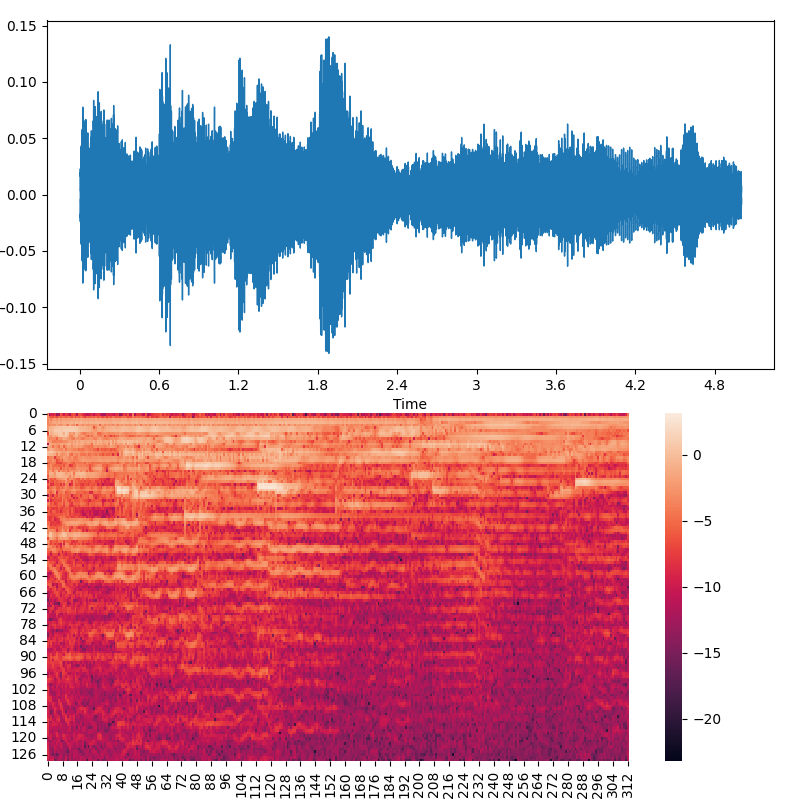

In [44]:
from Dataset import spectrogram as Dataset_spectogram
import torchvision

fig, axes = plt.subplots(2,1,figsize=(8,8))
fig.tight_layout()

#assuming bpm on average to be around ~120 and no note faster than a 64th-note 
#a note should not be shorter than ~31.25 ms
spec = Dataset_spectogram(samples2,SAMPLING_RATE)


librosa.display.waveshow(y=samples2.numpy(),sr=SAMPLING_RATE,ax=axes[0])
sns.heatmap(spec[0],ax=axes[1])
plt.show()

# Training p.t 2

In [45]:
# Mode 1: spectogram + flattening of samples
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=1,cache_size=400)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=1,cache_size=200)
train_ds[0][0].shape

torch.Size([40377])

### Linear models 

In [46]:
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.multioutput import MultiOutputClassifier
from params import *

composer = Perceptron(n_jobs=-1)
instrument = MultiOutputClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
model1 = SKModel(composer,instrument,withScalar=True)



# composer = SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001)
# instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.00001,learning_rate='adaptive',eta0=0.0001), n_jobs=-1)
# model2 = SKModel(composer,instrument,withScalar=True)


# composer = SGDClassifier(loss='log_loss',alpha=0.000001,learning_rate='adaptive',eta0=0.00001)
# instrument = MultiOutputClassifier(SGDClassifier(loss='log_loss',alpha=0.000001,learning_rate='adaptive',eta0=0.00001), n_jobs=-1)
# model3 = SKModel(composer,instrument,withScalar=True)


# composer = SGDClassifier(loss='hinge',alpha=0.0001)
# instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=0.0001), n_jobs=-1)
# model4 = SKModel(composer,instrument,withScalar=True)

composer = SGDClassifier(loss='log_loss',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='hinge',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model2 = SKModel(composer,instrument,withScalar=True)

composer = SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1)
instrument = MultiOutputClassifier(SGDClassifier(loss='modified_huber',alpha=ALPHA,learning_rate='adaptive',eta0=ETA0,n_jobs=-1), n_jobs=-1)
model3 = SKModel(composer,instrument,withScalar=True)




models2 = [model1,model2,model3]

In [47]:
models2, hist_comp2, hist_inst2, hist_models2 = train_loop(models2,train_loader,val_loader,epoches=EPOCHS)

EPOCH 0
epoch time: 8.463136434555054
train model 0:
exact match: 11.16%    accuracy composer: 36.65%    exact accuracy instrument: 20.32%
combined accuracy: 53.39%    accuracy instrument: 70.12% ->  ['72.51%', '72.91%', '68.92%', '80.48%', '57.37%', '68.53%', '66.14%', '70.12%', '72.51%', '71.71%']
train model 1:
exact match: 18.33%    accuracy composer: 39.84%    exact accuracy instrument: 26.29%
combined accuracy: 56.89%    accuracy instrument: 73.94% ->  ['74.50%', '88.05%', '82.47%', '86.45%', '72.91%', '66.93%', '66.53%', '67.33%', '68.92%', '65.34%']
train model 2:
exact match: 9.16%    accuracy composer: 34.26%    exact accuracy instrument: 19.12%
combined accuracy: 54.64%    accuracy instrument: 75.02% ->  ['76.10%', '88.05%', '81.27%', '86.45%', '67.33%', '72.11%', '68.13%', '74.10%', '74.50%', '62.15%']

val model 0:
exact match: 13.47%    accuracy composer: 34.83%    exact accuracy instrument: 18.64%
combined accuracy: 54.19%    accuracy instrument: 73.55% ->  ['57.55%', '8

### CNN


In [48]:
# mode 2 keeps the spectogram as an image. we also load up to 200 samples onto the gpu
train_ds,train_loader = get_dataloader(train_x,Y,64,mode=2,device=DEVICE,cache_size=200)
val_ds, val_loader = get_dataloader(val_x,Y,25,mode=2,device=DEVICE,cache_size=100)
train_ds[0][0].shape

torch.Size([1, 128, 312])

In [49]:
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
import torch


model_composer = nn.Sequential(
    nn.Conv2d(1,32,(3,7),stride=(1,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,32,(3,5),stride=(2,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    
    nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(128),

    nn.Conv2d(128,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    
    nn.Flatten(),
    nn.Linear(8*8*128,len(COMPOSER_CLASSES)),
    
)



model_instruments = nn.Sequential(
    nn.Conv2d(1,32,(3,7),stride=(1,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,32,(3,5),stride=(2,2),dilation=(1,4),padding=(1,0)),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    nn.Conv2d(32,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),
    
    nn.Conv2d(64,64,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(64),

    nn.Conv2d(64,128,(3,3),stride=1,padding="same"),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(128),
    
    nn.Flatten(),
    nn.Linear(8*8*128,len(INSTRUMENT_CLASSES)),
    
)
opt_composer = torch.optim.Adam(model_composer.parameters(),lr=COMPOSER_LEARNING_RATE,betas=(BETA1,BETA2))
opt_instrument = torch.optim.Adam(model_instruments.parameters(),lr=INSTRUMENT_LEARNING_RATE,betas=(BETA1,BETA2))

#### training loop

In [50]:
from torch.functional import F
import torch





def check_accuracy(model_composer,model_instruments, data_loader, name="",verbose=2):
	num_correct_1 = 0
	num_correct_2 = torch.zeros(len(INSTRUMENT_CLASSES),device=DEVICE)
	num_correct_3 = 0
	num_correct_4 = 0

	num_samples = 0
	
	model_composer.eval()  # set model to evaluation mode
	model_instruments.eval()
	
	with torch.no_grad():
		for x, y in data_loader:
			
			y1 = y[0].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			y2 = y[1].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			
			comp_scores = model_composer(x)
			inst_scores = model_instruments(x)

			comp_pred = torch.argmax(nn.Softmax(dim=1)(comp_scores),1)
		
			inst_pred = nn.Sigmoid()(inst_scores) > 0.5
			
			num_correct_1 += torch.sum(comp_pred==y1)
			num_correct_2 += torch.sum(inst_pred == (y2>0.5),0)
			num_correct_3 += torch.sum(torch.prod(inst_pred == (y2>0.5),1))
			correct_1 = comp_pred==y1
			correct_2 = torch.prod(inst_pred == (y2>0.5),1) == 1
			num_correct_4 += torch.sum(correct_1 * correct_2)
			
			num_samples += len(x)

			
			
	comp_accuracy = (num_correct_1/num_samples).cpu().numpy()
	inst_accuracies = (num_correct_2/num_samples).cpu().numpy()
	inst_exact_accuracy = (num_correct_3/num_samples).cpu().numpy()
	exact_accuracy = (num_correct_4/num_samples).cpu().numpy()
	overall_accuracy = ((comp_accuracy + np.mean(inst_accuracies))/2)

	
	if verbose > 0:
		printPerformance(comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy, level=verbose,name = name)
	return  comp_accuracy, inst_accuracies, inst_exact_accuracy, exact_accuracy, overall_accuracy



def train_nn(model_composer:nn.Sequential, model_instruments:nn.Sequential,
		  loader_train, loader_val,
		  optimizer_comp:torch.optim, optimizer_inst:torch.optim,
		  lossFunction_comp=F.cross_entropy, lossFunction_inst=F.multilabel_soft_margin_loss, 
		  verbose = 0,save_checkpoints=None,eval_every=EVAL_EVERY, epoches=EPOCHS):
	
	hist_comp = {"train_loss":{},"train_accuracy":{},"val_accuracy":{}}
	hist_inst= {"train_loss":{},"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}}
	hist_model = {"train_accuracy":{},"val_accuracy":{},"train_accuracy_exact":{},"val_accuracy_exact":{}}
	model_composer = model_composer.to(device=DEVICE)
	model_instruments = model_instruments.to(device=DEVICE)
	for e in range(epoches):
		if verbose > 0:
			print('EPOCH %d' % (e))
			
		start = time.time()
		for i, (x, y) in enumerate(loader_train):

			model_composer.train()  # put model to training mode
			model_instruments.train()  # put model to training mode
			
			optimizer_comp.zero_grad()
			optimizer_inst.zero_grad()
			
			#x = x.to(device=DEVICE,dtype=torch.float32)  # move to device, e.g. GPU
			comp_scores = model_composer(x)
			inst_scores = model_instruments(x)
			
			y1 = y[0].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			y2 = y[1].to(device=DEVICE,dtype=torch.long)  # move to device, e.g. GPU
			comp_loss = lossFunction_comp(comp_scores,y1)
			inst_loss = lossFunction_inst(inst_scores,y2)

			comp_loss.backward()
			inst_loss.backward()
			
			hist_comp["train_loss"][e] = comp_loss.item()
			hist_inst["train_loss"][e] = inst_loss.item()

			optimizer_comp.step()
			optimizer_inst.step()
			

		if verbose > 0:
			print("epoch time:",time.time()-start)
		


		if verbose > 0:
			new_verb = verbose + int(e%eval_every == 0 or e==epoches-1) - 2
			acc1,acc2,acc3,acc4,acc5 = check_accuracy(model_composer,model_instruments,loader_train,"train",verbose=new_verb)
			if verbose > 2:
				print('composer model loss: = %.4f, instrument model loss:  %.4f' % (comp_loss.item(), inst_loss.item()))
			hist_comp["train_accuracy"][e]=acc1
			hist_inst["train_accuracy"][e]=acc2
			hist_inst["train_accuracy_exact"][e] = acc3
			hist_model["train_accuracy_exact"][e] = acc4
			hist_model["train_accuracy"][e] = acc5

		if verbose>0 and (e%eval_every == 0 or e==epoches-1):
			acc1,acc2,acc3,acc4,acc5  = check_accuracy(model_composer,model_instruments,loader_val,"val",verbose=verbose-1)
			if verbose > 1:
				print("----------------------------------------------")
				print("")
				print("")
			hist_comp["val_accuracy"][e]=acc1
			hist_inst["val_accuracy"][e]=acc2
			hist_inst["val_accuracy_exact"][e] = acc3
			hist_model["val_accuracy_exact"][e] = acc4
			hist_model["val_accuracy"][e] = acc5

			if save_checkpoints != None:
				torch.save(model_composer,"checkpoints/composer/"+save_checkpoints+str(e)+".pth")
				torch.save(model_instruments,"checkpoints/instrument/"+save_checkpoints+str(e)+".pth")
		
	# train_acc_comp,train_acc_inst = check_accuracy(model_composer,model_instruments,loader_train,"train")
	# val_acc_comp,val_acc_inst = check_accuracy(model_composer,model_instruments,loader_val,"val")
	
	# hist_comp["train_accuracy"][e] = train_acc_comp
	# hist_comp["val_accuracy"][e] = val_acc_comp

	# hist_inst["train_accuracy"][e] = train_acc_inst
	# hist_inst["val_accuracy"][e] = val_acc_inst

	return model_composer, model_instruments, hist_comp, hist_inst, hist_model

#### fitting

In [51]:
model_composer, model_instruments, hist_comp3, hist_inst3, hist_models3 = train_nn(model_composer,model_instruments,train_loader,val_loader,opt_composer,opt_instrument,verbose=4,save_checkpoints="first",eval_every=EVAL_EVERY,epoches=EPOCHS)

EPOCH 0
epoch time: 3.026000738143921
train: accuracy composer: 16.83%    accuracy instrument: 68.10% ->  ['52.38%', '73.33%', '71.75%', '53.65%', '73.02%', '78.73%', '45.40%', '81.59%', '81.90%', '69.21%']
composer model loss: = 1.7993, instrument model loss:  0.5209
val: accuracy composer: 13.20%    accuracy instrument: 67.24% ->  ['54.42%', '71.56%', '69.93%', '54.15%', '76.87%', '83.27%', '41.09%', '80.27%', '74.83%', '65.99%']
----------------------------------------------


EPOCH 1
epoch time: 0.9955000877380371
train: accuracy composer: 16.83%    accuracy instrument: 74.76% ->  ['54.92%', '73.02%', '69.52%', '73.02%', '67.62%', '79.05%', '86.98%', '78.41%', '80.00%', '85.08%']
composer model loss: = 1.6009, instrument model loss:  0.4501
EPOCH 2
epoch time: 0.9190006256103516
train: accuracy composer: 16.83%    accuracy instrument: 71.43% ->  ['59.37%', '67.62%', '60.95%', '64.44%', '58.10%', '79.68%', '81.59%', '80.63%', '79.05%', '82.86%']
composer model loss: = 1.4216, instru

# Evaluation
Let's compare the online models and finally choose the best one to use for our testing data

## Model performances during training
### Overall performance
Let's see how well the models performed across both instrument classification and composer at the same time

(<Figure size 1000x350 with 2 Axes>,
 array([<Axes: title={'center': 'Train accuracy'}, xlabel='epoch', ylabel='accuracy'>,
        <Axes: title={'center': 'Validation accuracy'}, xlabel='epoch'>],
       dtype=object))

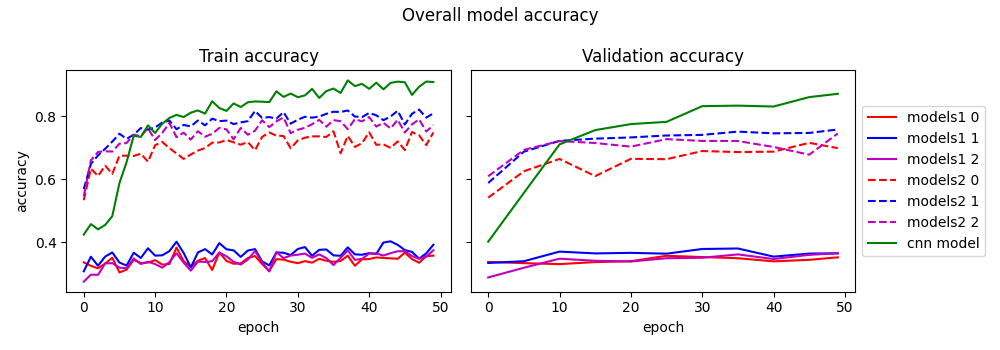

In [52]:
def plot_models_accuracy_together(hist1,hist2,hist3,train_key = "train_accuracy",val_key="val_accuracy", title=""):

    fig, axes = plt.subplots(1,2,figsize=(10,3.5),sharex=True,sharey=True)

    colors = ['r','b','m','c']

    for i, hist in enumerate(hist1):
        axes[0].plot(hist[train_key].keys(),hist[train_key].values(),color=colors[i])
        axes[1].plot(hist[val_key].keys(),hist[val_key].values(),color=colors[i],label=f"models1 {i}")


    for i, hist in enumerate(hist2):
        axes[0].plot(hist[train_key].keys(),hist[train_key].values(),'--',color=colors[i])
        axes[1].plot(hist[val_key].keys(),hist[val_key].values(),'--',color=colors[i],label=f"models2 {i}")


    axes[0].plot(hist3[train_key].keys(),hist3[train_key].values(),color='g')
    axes[1].plot(hist3[val_key].keys(),hist3[val_key].values(),color='g',label="cnn model")

    axes[0].set_title("Train accuracy")
    axes[1].set_title("Validation accuracy")
    axes[0].set_xlabel("epoch")
    axes[1].set_xlabel("epoch")
    axes[0].set_ylabel("accuracy")

    axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    fig.suptitle(title)
    fig.tight_layout()
    return fig, axes

plot_models_accuracy_together(hist_models1,hist_models2,hist_models3,title="Overall model accuracy")

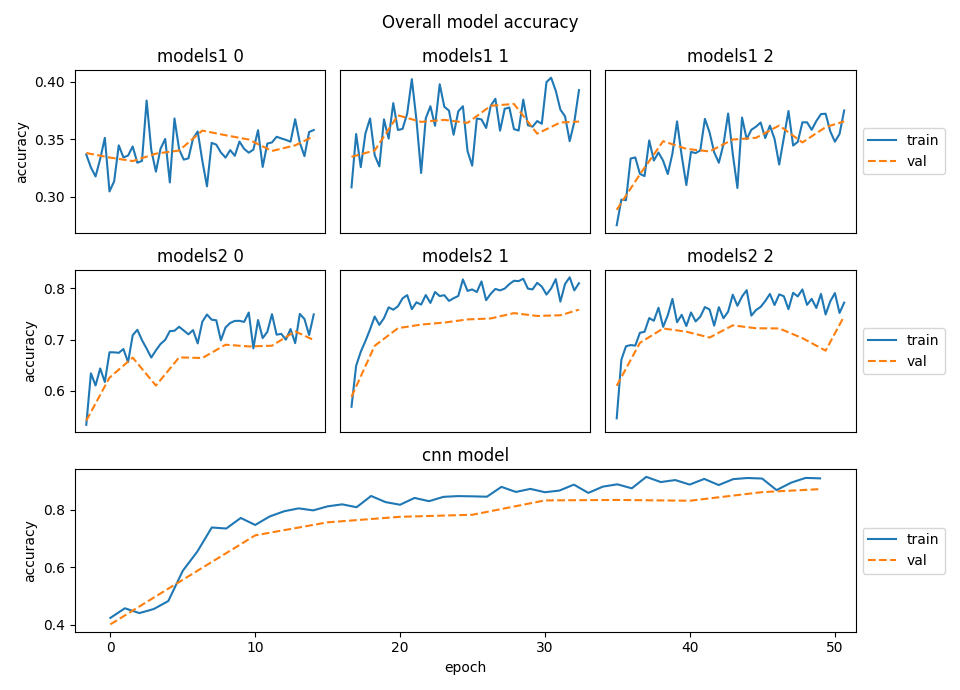

In [56]:
from matplotlib.gridspec import GridSpec
def plot_separate_accuracies(hist1,hist2,hist3,title="", train_key="train_accuracy",val_key="val_accuracy"):
    fig = plt.figure(figsize=(len(hist1)*3.2,2.3*3))
    gs = GridSpec(3, len(hist1), figure=fig)


    axes = []
    for i in range(len(hist1)):
        if i == 0:
            axes.append(fig.add_subplot(gs[0, i]))
            axes[i].tick_params(labelbottom = False, bottom = False) 
        else:
            axes.append(fig.add_subplot(gs[0, i],sharey=axes[-1]))
            axes[i].tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 
    for i, hist in enumerate(hist1):
        axes[i].plot(hist[train_key].keys(),hist[train_key].values(),label=f"train")
        axes[i].plot(hist[val_key].keys(),hist[val_key].values(),'--',label=f"val")
        axes[i].set_title(f"models1 {i}")
        

    axes[-1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axes[0].set_ylabel("accuracy")



    axes2 = []
    for i in range(len(hist1)):
        if i == 0:
            axes2.append(fig.add_subplot(gs[1, i],sharex=axes[i]))
            axes2[i].tick_params(labelbottom = False, bottom = False) 
        else:
            axes2.append(fig.add_subplot(gs[1, i],sharex=axes[i],sharey=axes2[-1]))
            axes2[i].tick_params(left = False, labelleft = False , labelbottom = False, bottom = False) 

    for i, hist in enumerate(hist2):
        axes2[i].plot(hist[train_key].keys(),hist[train_key].values(),label=f"train")
        axes2[i].plot(hist[val_key].keys(),hist[val_key].values(),'--',label=f"val")
        axes2[i].set_title(f"models2 {i}")
    axes2[-1].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axes2[0].set_ylabel("accuracy")

    ax = fig.add_subplot(gs[2, :])
    ax.plot(hist3[train_key].keys(),hist3[train_key].values(),label="train")
    ax.plot(hist3[val_key].keys(),hist3[val_key].values(),'--',label="val")
    ax.set_title(f"cnn model")

    ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    ax.set_ylabel("accuracy")
    ax.set_xlabel("epoch")

    fig.suptitle(title)
    fig.tight_layout()

plot_separate_accuracies(hist_models1,hist_models2,hist_models3,"Overall model accuracy")

(<Figure size 1000x350 with 2 Axes>,
 array([<Axes: title={'center': 'Train accuracy'}, xlabel='epoch', ylabel='accuracy'>,
        <Axes: title={'center': 'Validation accuracy'}, xlabel='epoch'>],
       dtype=object))

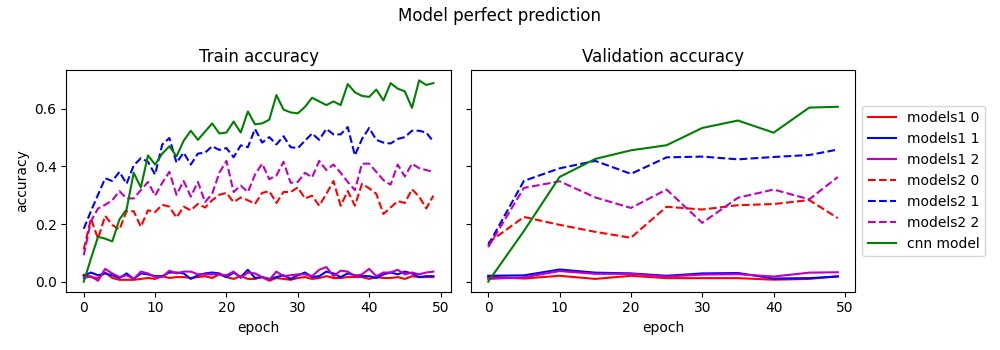

In [57]:
plot_models_accuracy_together(hist_models1,hist_models2,hist_models3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Model perfect prediction")

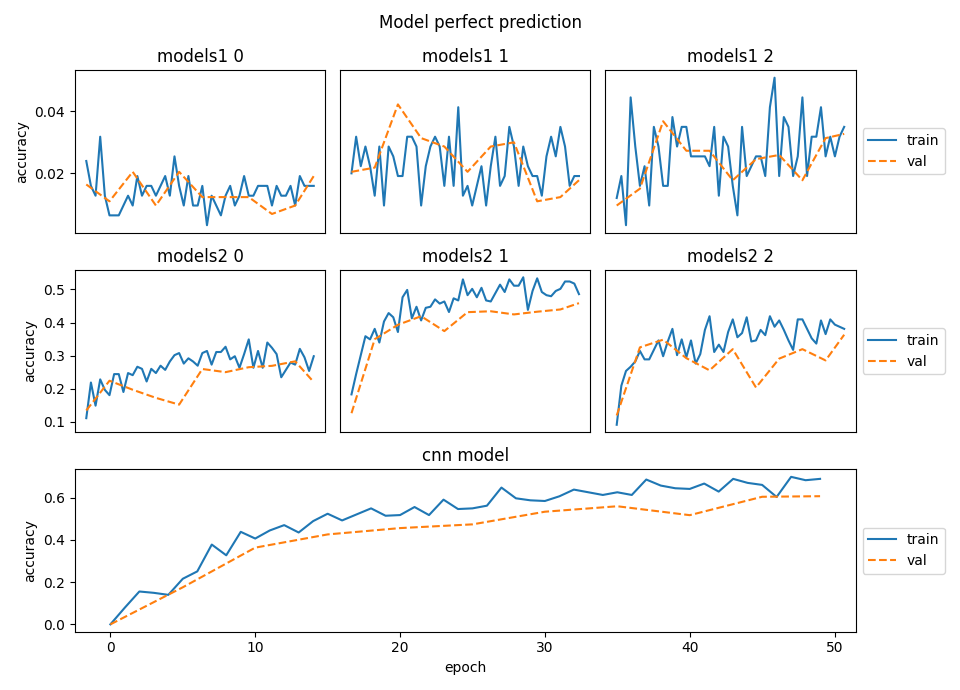

In [58]:
plot_separate_accuracies(hist_models1,hist_models2,hist_models3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Model perfect prediction")

### Composer classification performance
Now let's review the models capabilities to classify composers alone

(<Figure size 1000x350 with 2 Axes>,
 array([<Axes: title={'center': 'Train accuracy'}, xlabel='epoch', ylabel='accuracy'>,
        <Axes: title={'center': 'Validation accuracy'}, xlabel='epoch'>],
       dtype=object))

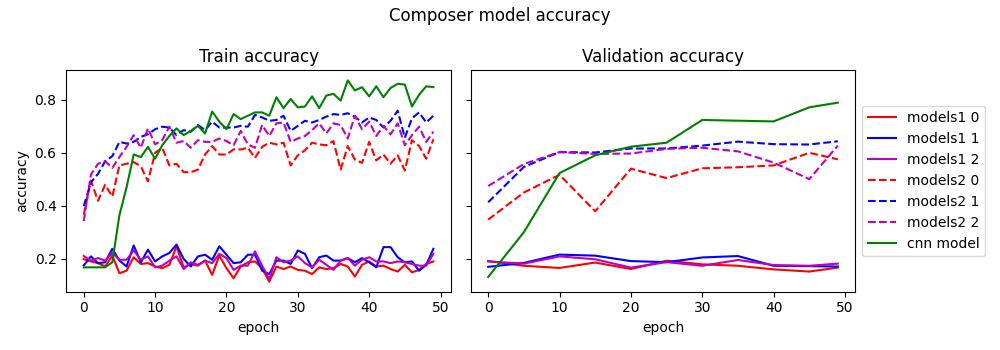

In [66]:
plot_models_accuracy_together(hist_comp1,hist_comp2,hist_comp3,title="Composer model accuracy")

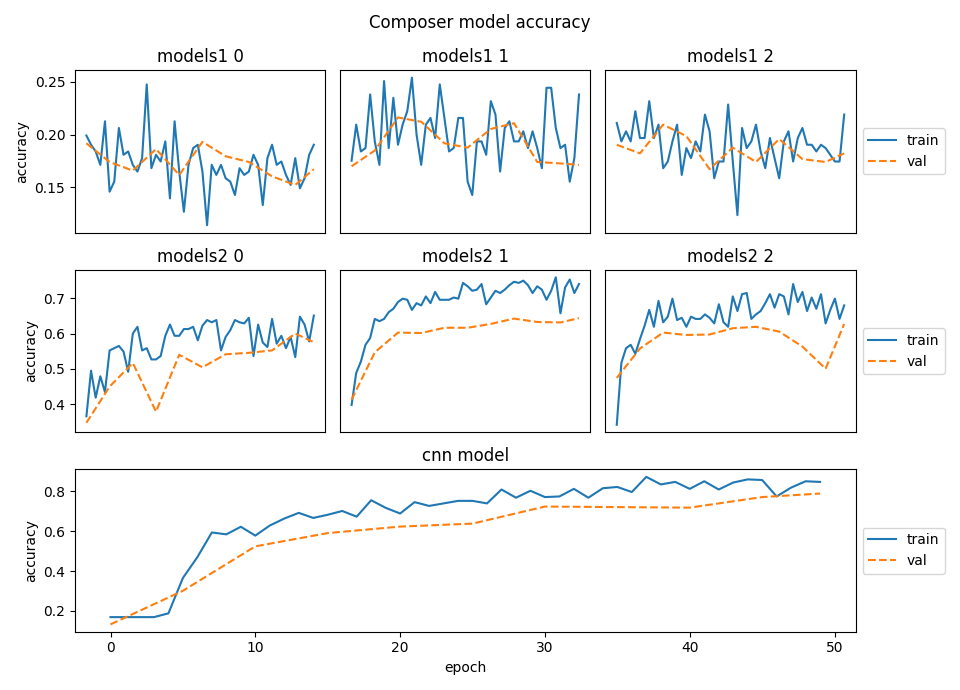

In [67]:
plot_separate_accuracies(hist_comp1,hist_comp2,hist_comp3,title="Composer model accuracy")

We can clearly see that transforming the audio data into a spectogram greatly increased the models performance, it seems that given more epoches, a linear model might come close to the CNN

### Instrument classification performance

First we will look at how good the model is in classifying each instrument alone, then look at how good the model is at perfectly classifying all instruments

In [59]:
def plot_hist_inst(hist,axes,color='g', name=""):
    def get_arr_data(hist):
        accs = []
        for acc in hist.values():
            if type(acc) == torch.Tensor:
                accs.append(acc.numpy())
            else:
                accs.append(acc)
        
        return np.array(accs)

    train_accs = get_arr_data(hist["train_accuracy"])
    val_accs = get_arr_data(hist["val_accuracy"])
    for i in range(train_accs.shape[1]):
        axes[i%len(axes), i//len(axes)].plot(hist["train_accuracy"].keys(),train_accs[:,i],label = f"{name} train",color=color)
        axes[i%len(axes), i//len(axes)].plot(hist["val_accuracy"].keys(),val_accs[:,i],'--',label=f"{name} val",color=color)
        axes[i%len(axes), i//len(axes)].set_title(f"instrument {i}")

Text(0.5, 0.98, 'Linear models 1 accuracy')

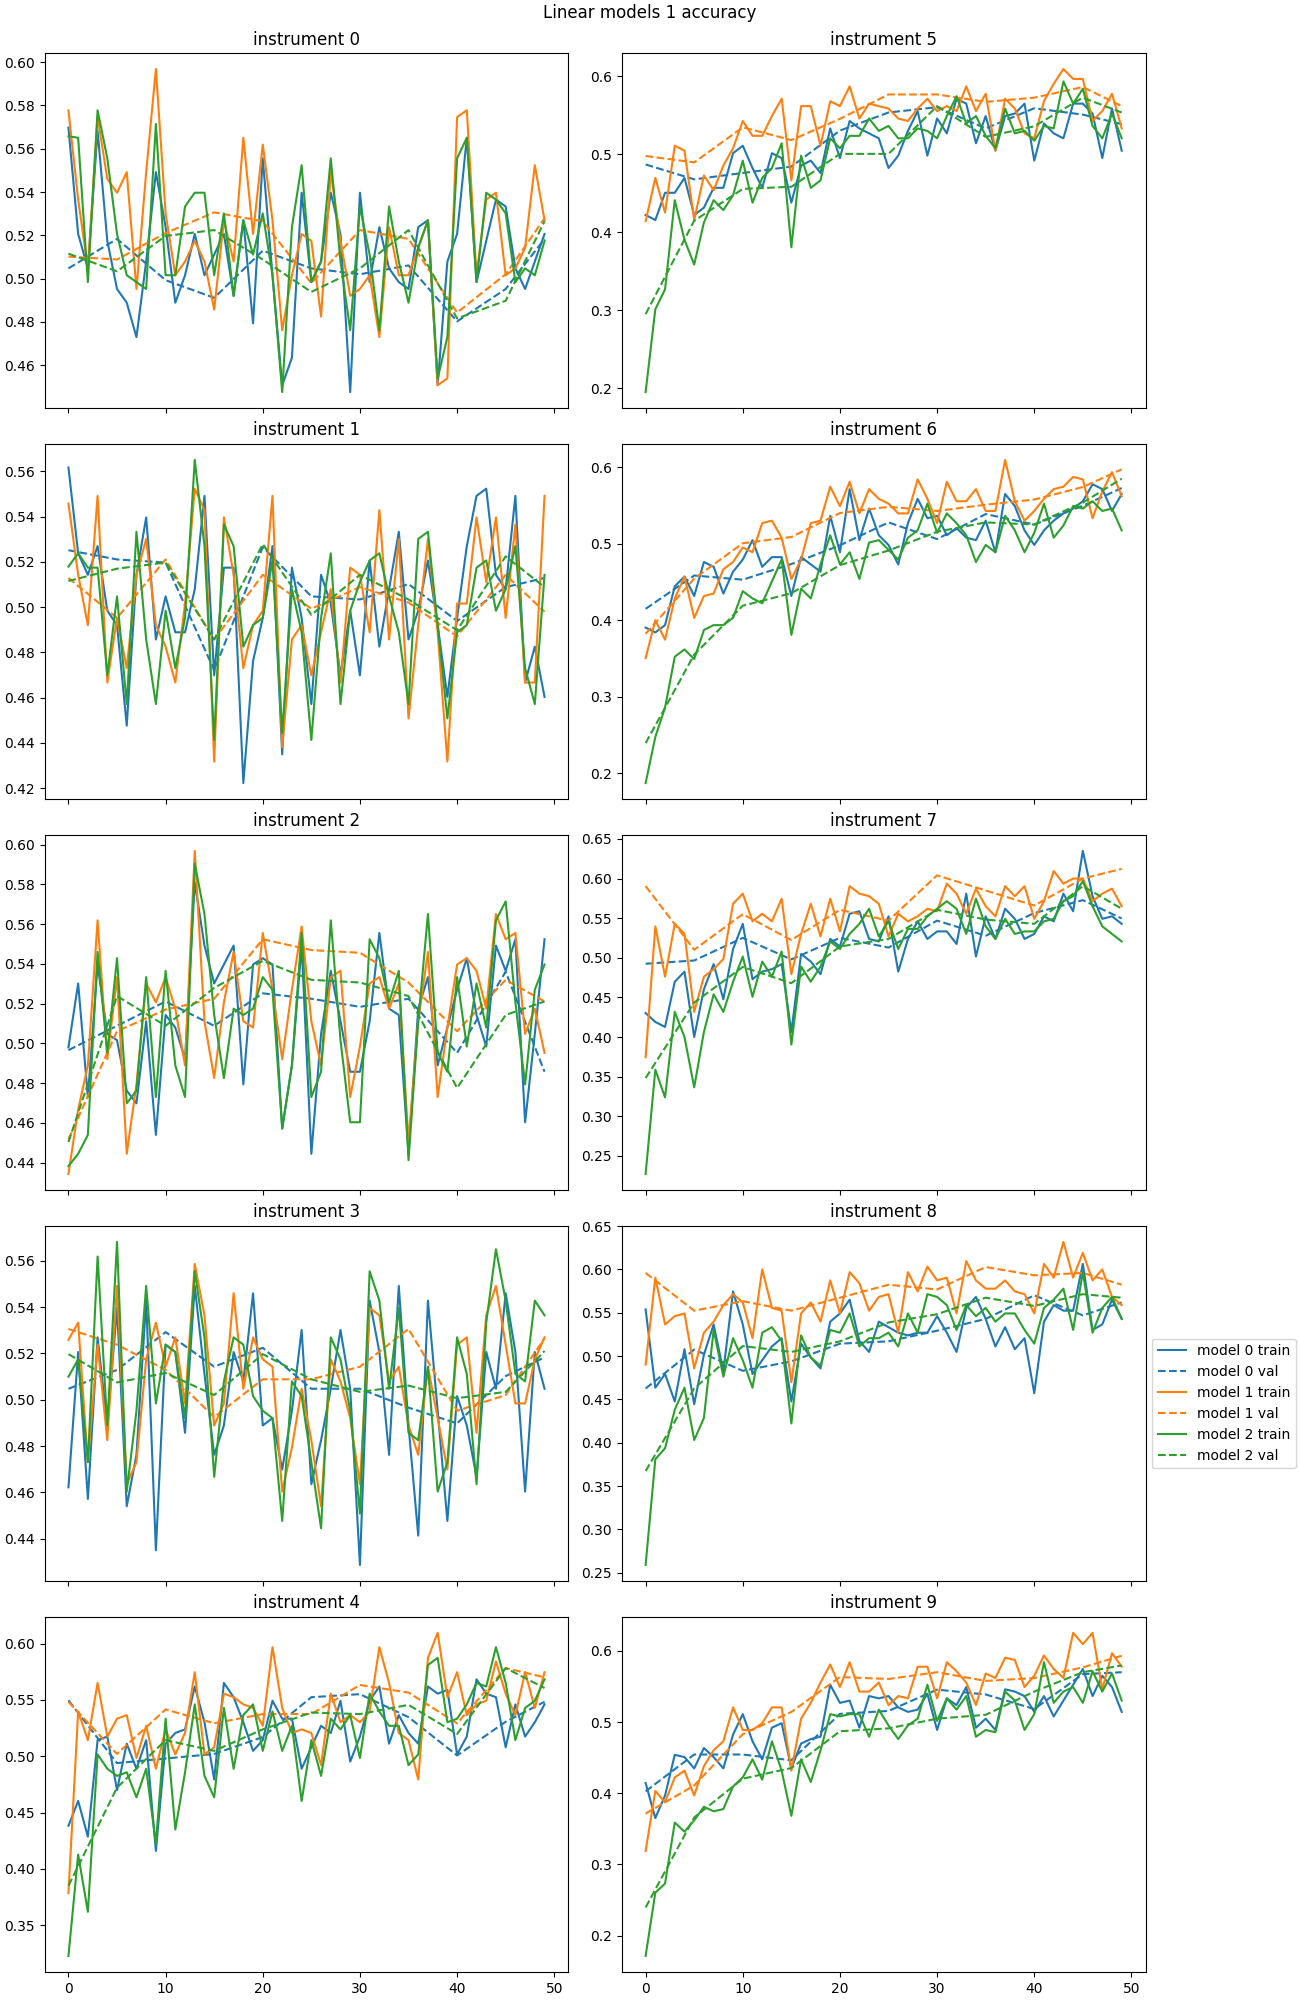

In [60]:
fig, axes = plt.subplots(5,2,figsize=(13,20),sharex=True,sharey=False,constrained_layout=True)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']


for i,hist in enumerate(hist_inst1):
    plot_hist_inst(hist,axes,colors[i],name=f"model {i}")
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))
fig.suptitle("Linear models 1 accuracy")


Text(0.5, 0.98, 'Linear models 2 accuracy')

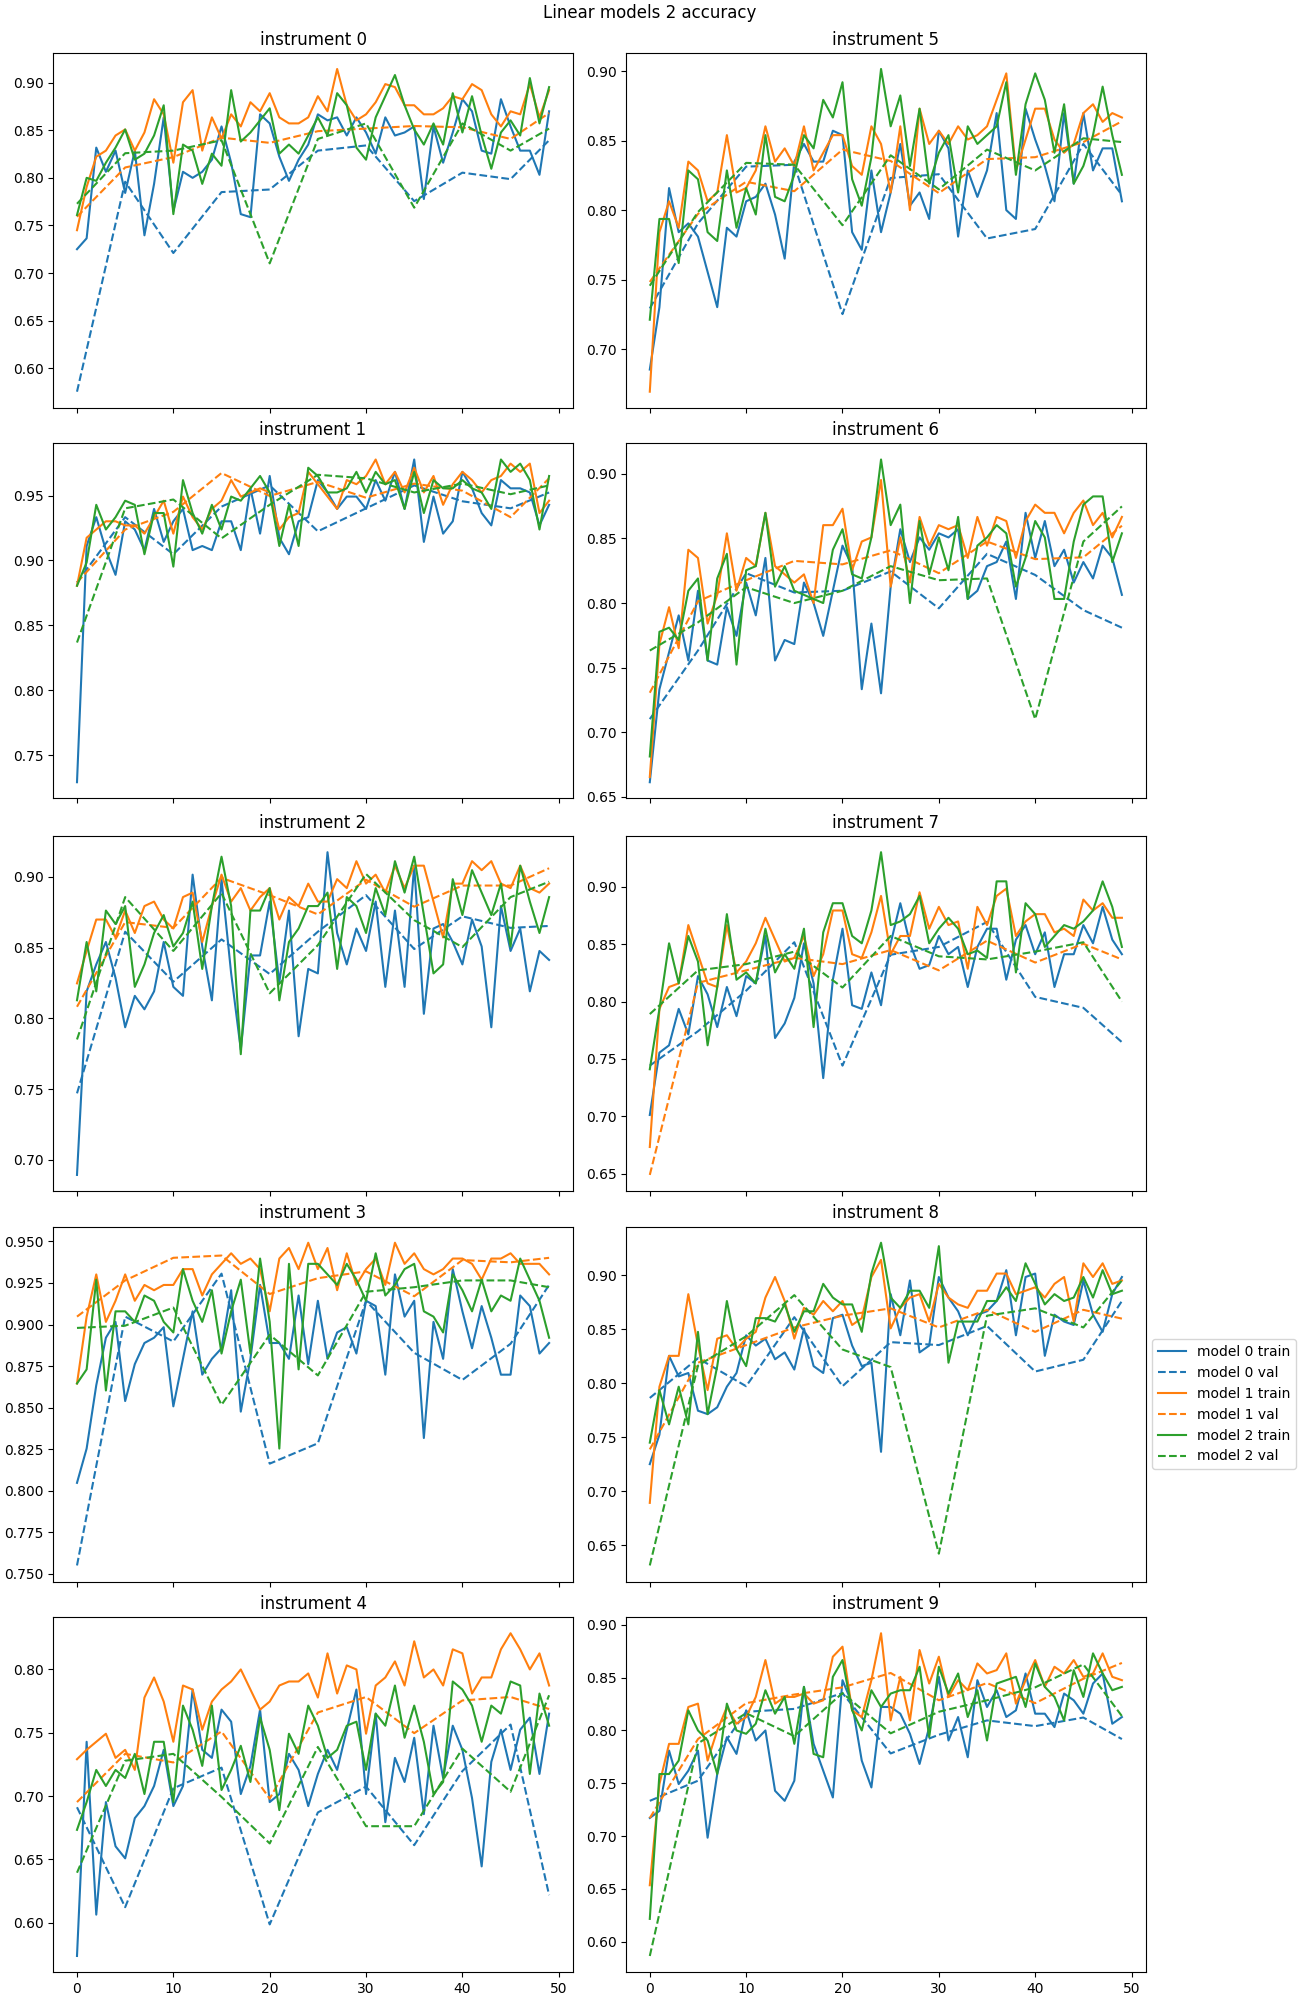

In [65]:
fig, axes = plt.subplots(5,2,figsize=(13,20),sharex=True,sharey=False,constrained_layout=True)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:pink']

for i,hist in enumerate(hist_inst2):
    plot_hist_inst(hist,axes,colors[i],name=f"model {i}")
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))
fig.suptitle("Linear models 2 accuracy")


Text(0.5, 0.98, 'CNN model accuracy')

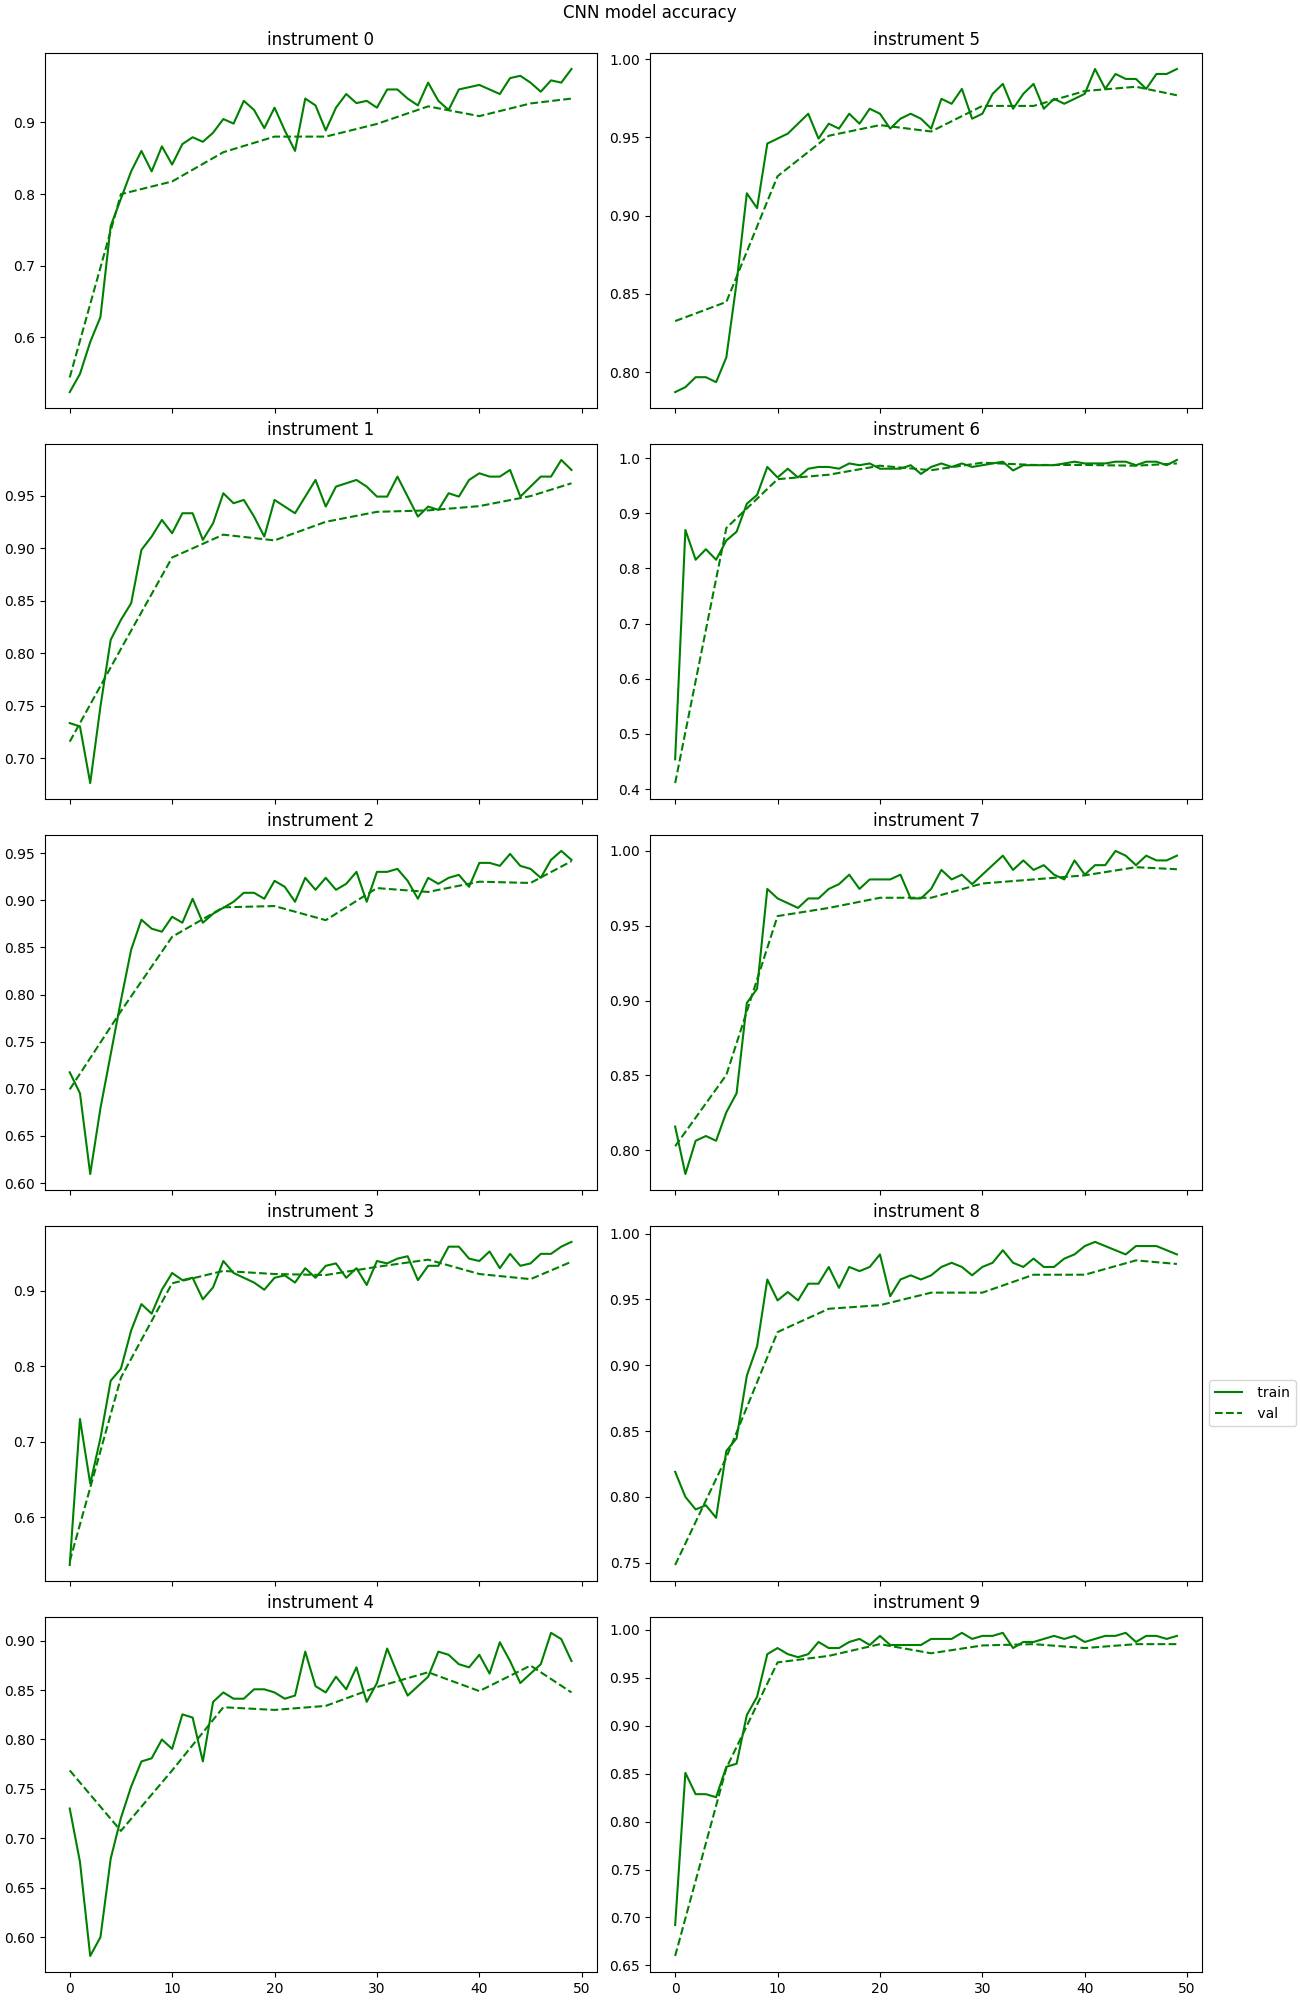

In [62]:
fig, axes = plt.subplots(5,2,figsize=(13,20),sharex=True,sharey=False,constrained_layout=True)

plot_hist_inst(hist_inst3,axes)
axes[3,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

fig.suptitle("CNN model accuracy")

Let's see how many times the instrument models managed to perfectly classify all instruments

(<Figure size 1000x350 with 2 Axes>,
 array([<Axes: title={'center': 'Train accuracy'}, xlabel='epoch', ylabel='accuracy'>,
        <Axes: title={'center': 'Validation accuracy'}, xlabel='epoch'>],
       dtype=object))

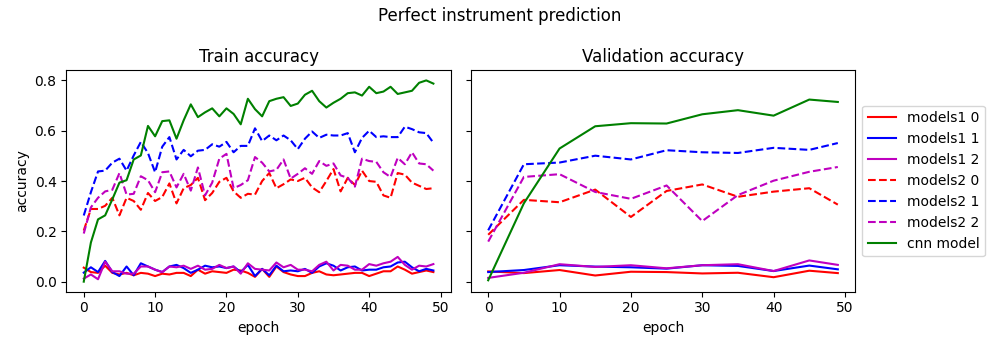

In [63]:
plot_models_accuracy_together(hist_inst1,hist_inst2,hist_inst3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Perfect instrument prediction")

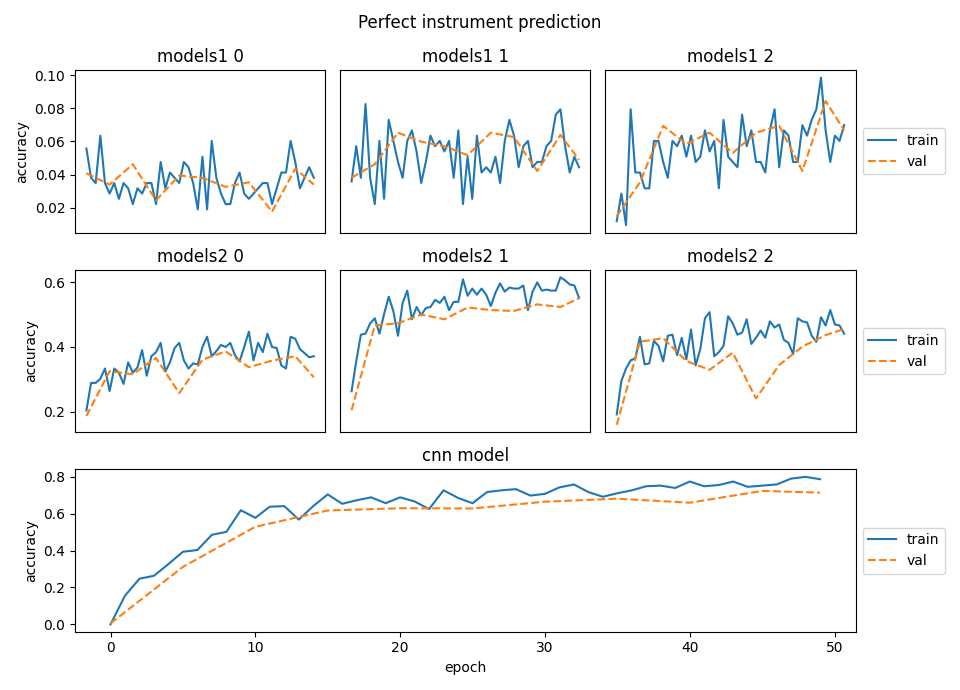

In [64]:
plot_separate_accuracies(hist_inst1,hist_inst2,hist_inst3,train_key="train_accuracy_exact",val_key="val_accuracy_exact",title="Perfect instrument prediction")

In all the graphs we saw that the CNN model has the smoothest increase in both train and validation. Since the CNN trains at a much faster rate, I will be training it for some more epoches before testing it.

In [68]:
model_composer, model_instruments, hist_comp4, hist_inst4, hist_models4 = train_nn(model_composer,model_instruments,train_loader,val_loader,opt_composer,opt_instrument,verbose=4,save_checkpoints="second",eval_every=EVAL_EVERY,epoches=EPOCHS)

EPOCH 0
epoch time: 1.610499382019043
train: accuracy composer: 84.13%    accuracy instrument: 96.38% ->  ['93.65%', '96.51%', '93.65%', '93.97%', '89.21%', '99.37%', '99.37%', '99.68%', '98.41%', '100.00%']
composer model loss: = 0.3384, instrument model loss:  0.0754
val: accuracy composer: 76.46%    accuracy instrument: 95.22% ->  ['93.74%', '94.69%', '93.06%', '93.88%', '85.44%', '97.69%', '99.18%', '98.64%', '97.41%', '98.50%']
----------------------------------------------


EPOCH 1
epoch time: 1.0179991722106934
train: accuracy composer: 84.13%    accuracy instrument: 96.63% ->  ['95.56%', '97.78%', '95.87%', '95.24%', '88.89%', '97.78%', '99.05%', '99.05%', '97.78%', '99.37%']
composer model loss: = 0.3554, instrument model loss:  0.0805
EPOCH 2
epoch time: 0.9189996719360352
train: accuracy composer: 87.94%    accuracy instrument: 96.70% ->  ['93.97%', '96.51%', '94.29%', '96.19%', '90.79%', '98.73%', '99.05%', '99.37%', '99.37%', '98.73%']
composer model loss: = 0.3919, instr

In [71]:
tmp = hist_comp3
def updateHist(hist1,hist2):
    for entry in hist2:
        hist1[entry].update({k+len(hist1[entry]):v for k,v in hist2[entry].items()})

    return hist1

hist_comp = updateHist(hist_comp3,hist_comp4)
hist_inst = updateHist(hist_inst3,hist_inst4)
hist_model = updateHist(hist_models3,hist_models4)


# Test

In [72]:
test_ds,test_loader = get_dataloader(test_x,test_y,25,False,mode=2,device=DEVICE,cache_size=200)
test_x.shape

(37,)

In [99]:
def test_model(model_composer,model_instruments, test_loader, factor = 1):
    comp_pred = []
    inst_pred = []
    test_raw_y1 = []
    test_raw_y2 = []
    with torch.no_grad():
        for i in range(factor):
            for x,y in test_loader:
                comp_scores = model_composer(x)
                inst_scores = model_instruments(x)
                test_raw_y1 = test_raw_y1 + y[0].cpu().tolist()
                test_raw_y2 = test_raw_y2 + y[1].cpu().tolist()
                comp_pred = comp_pred + torch.argmax(nn.Softmax(dim=1)(comp_scores),1).cpu().tolist()
                inst_pred = inst_pred + (1*(nn.Sigmoid()(inst_scores) > 0.5)).cpu().tolist()

    return test_raw_y1,comp_pred, test_raw_y2, inst_pred



y_real1, comp_pred, y_real2, inst_pred = test_model(model_composer,model_instruments,test_loader,factor=40)

In [100]:
print(classification_report(y_real1,comp_pred))

              precision    recall  f1-score   support

           0       0.96      0.76      0.85       320
           1       0.74      0.48      0.59       560
           2       0.50      0.64      0.56       160
           3       0.83      0.97      0.90        80
           4       0.52      0.85      0.65        40
           5       0.46      0.67      0.55       200
           6       0.37      0.63      0.47       120

    accuracy                           0.64      1480
   macro avg       0.63      0.72      0.65      1480
weighted avg       0.69      0.64      0.64      1480



In [102]:
print(classification_report(y_real2,inst_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       760
           1       0.89      0.95      0.92       680
           2       0.76      0.83      0.79       360
           3       0.78      0.86      0.82       600
           4       0.61      0.39      0.48       360
           5       0.88      0.99      0.93       280
           6       0.62      0.89      0.73       120
           7       0.92      0.99      0.95       240
           8       0.85      0.80      0.82       400
           9       0.82      0.66      0.73       120

   micro avg       0.84      0.84      0.84      3920
   macro avg       0.81      0.82      0.81      3920
weighted avg       0.83      0.84      0.83      3920
 samples avg       0.86      0.86      0.84      3920



c:\Users\Ziv\Desktop\University\year_4\Semester_2\machine_learning\project\.conda\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


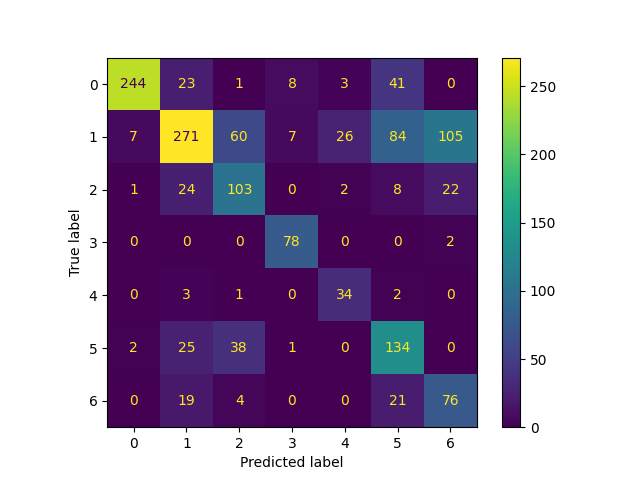

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_real1, comp_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()


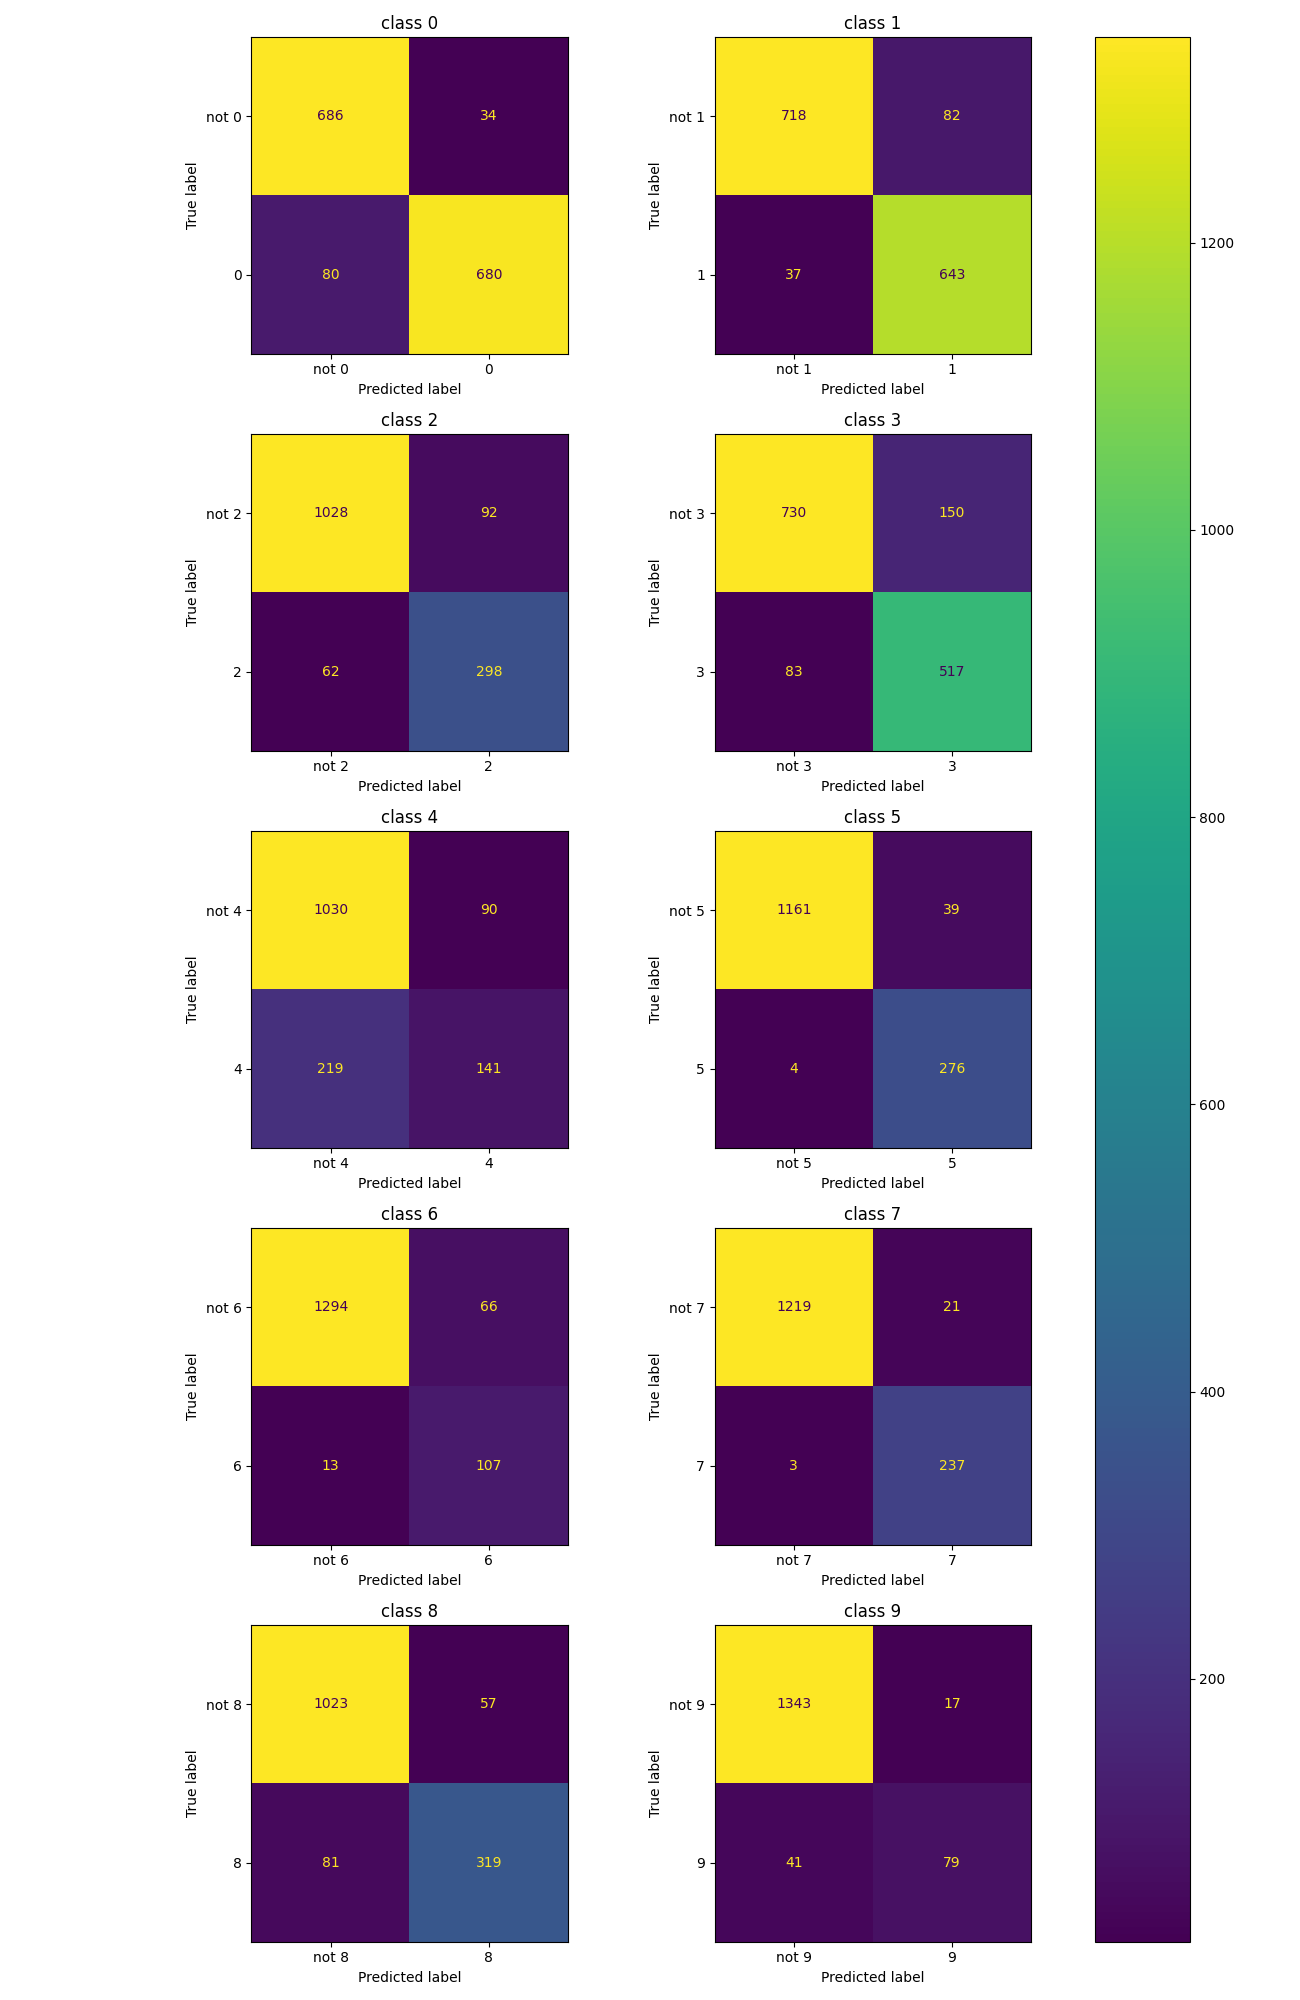

In [117]:
f, axes = plt.subplots(5, 2, figsize=(13,20))
axes = axes.ravel()
y_real2 = np.array(y_real2)
inst_pred = np.array(inst_pred)


for i in range(len(axes)):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_real2[:, i],inst_pred[:, i]),display_labels=[f'not {i}', i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    
    disp.im_.colorbar.remove()

f.tight_layout()
f.colorbar(disp.im_, ax=axes)
plt.show()